In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.decomposition import PCA

import joblib

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

2024-10-22 07:23:00.839480: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 07:23:01.106888: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 07:23:01.176748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 07:23:01.354111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 07:23:01.386142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 07:23:01.590224: I tensorflow/core/platform/cpu_feature_gu

In [3]:
file_path = ['/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/new_datasets/dataset1/RS_Energie_V_AL_2007.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/new_datasets/dataset1/RS_Energie_V_S235JR.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/new_datasets/dataset2/AL_RS_Energie.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/new_datasets/dataset2/S_RS_Energie.csv']

In [4]:
not_non_features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',
        

       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
target = 'CURRENT|6'

## Unsupervised PCA

In [13]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_Unsupervised/'

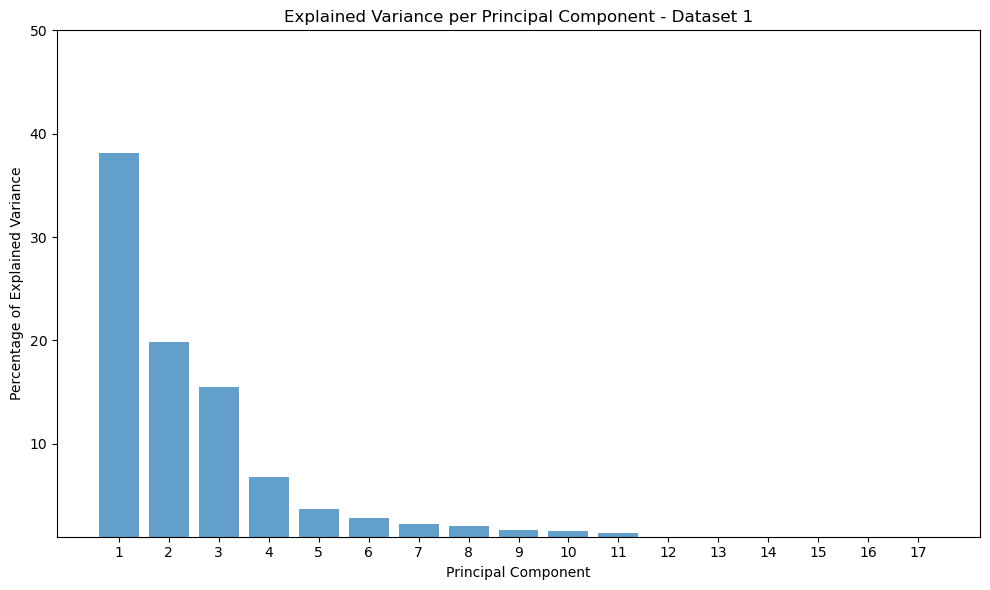

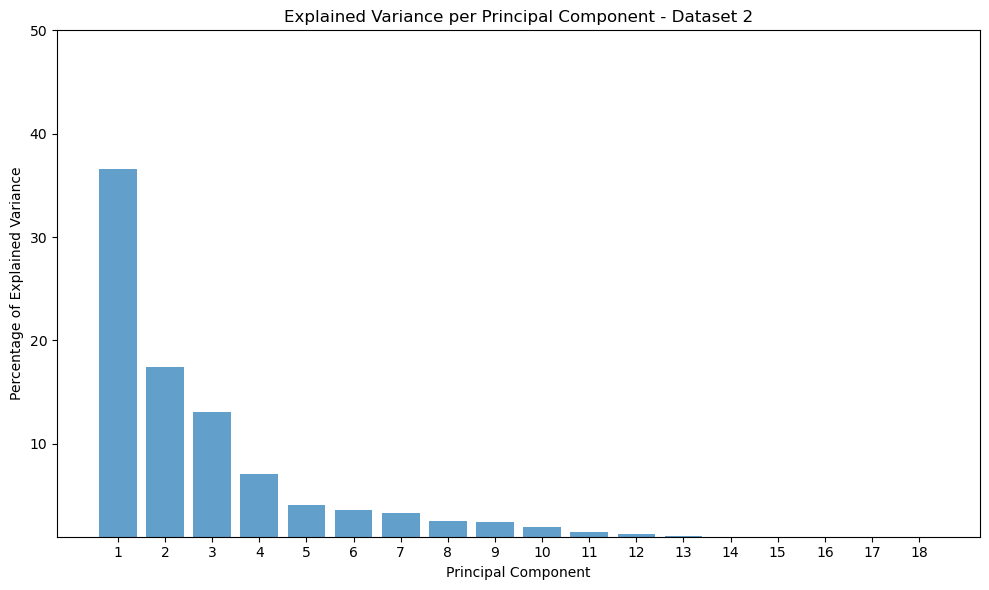

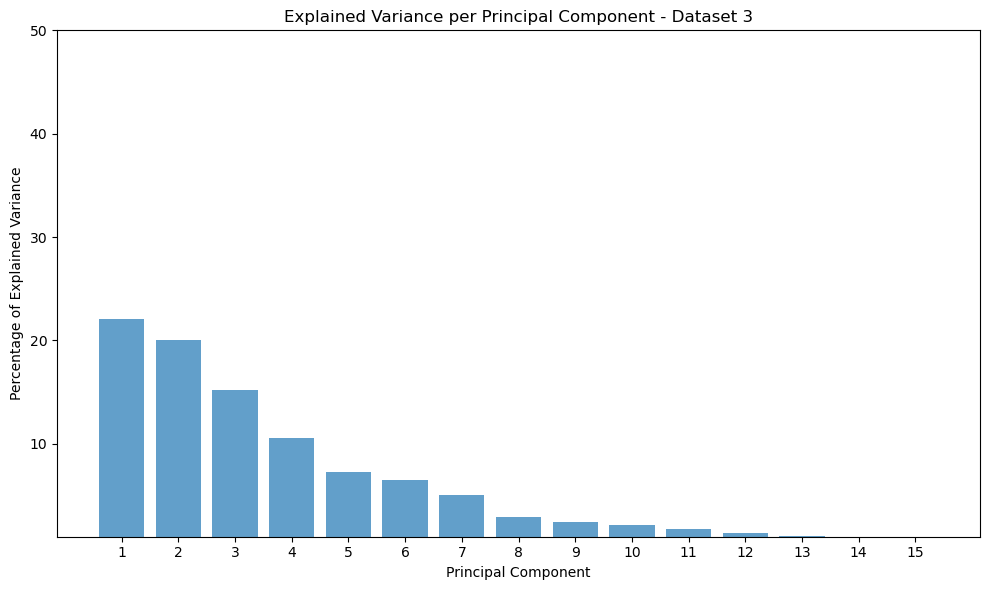

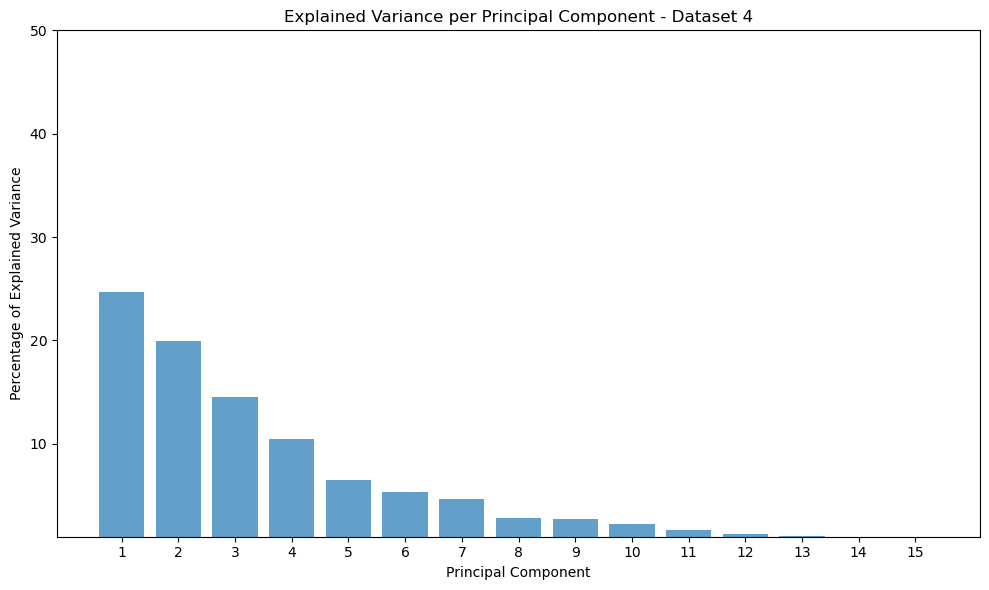

In [14]:
k = 1
for file in file_path:
    #file = file_path[i]
    df = pd.read_csv(file)
    df = df[not_non_features]
    X = df.values
    sc = StandardScaler()
    X_std = sc.fit_transform(X)

    pca = PCA(n_components=0.99)
    X_pca = pca.fit_transform(X_std)
    n_pcs = pca.n_components_
    explained_variance_ratio = pca.explained_variance_ratio_
    components = pca.components_

    feature_contributions = pd.DataFrame(components, columns=df.columns)
    feature_contributions.index = [f"PC{i+1}" for i in range(n_pcs)]
    feature_contributions_file = os.path.join(output_folder, f"fc_{os.path.basename(file)}.csv")
    feature_contributions.to_csv(feature_contributions_file)

    explained_variance_list = [
        f"PC{i+1}: {explained_variance_ratio[i]:.4f}" for i in range(n_pcs)
    ]
    top_features_list = []
    for j in range(n_pcs):
        top_features = feature_contributions.iloc[j].abs().nlargest(4).index.tolist()
        top_features_list.append(f"{', '.join(top_features)}")

    explained_variance_df = pd.DataFrame({
        'Principal Component': [f"PC{i+1}" for i in range(n_pcs)],
        'Explained Variance': explained_variance_ratio,
        'Top Features': top_features_list
    })
    explained_variance_file = os.path.join(output_folder, f"ev_{os.path.basename(file)}.csv")
    explained_variance_df.to_csv(explained_variance_file, index=False)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_pcs + 1), explained_variance_ratio * 100, alpha=0.7, align='center')
    plt.xticks(range(1, n_pcs + 1), range(1, n_pcs + 1))  
    plt.ylim(1, 50)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title(f'Explained Variance per Principal Component - Dataset {k}')
    plt.tight_layout()
    plt.show()

    k += 1


### LSTM on PCs

In [5]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_LSTM'
input_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_Unsupervised'
result_df = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Train_RMSE', 'Test_R2', 'Test_RMSE'])
filenamefinal = os.path.join(output_folder, f'result_lstm_pca1-4_7030.csv')

In [9]:
i = 1
for file in file_path:
        df = pd.read_csv(file)
        pca_info = pd.read_csv(os.path.join(input_folder, f"ev_{os.path.basename(file)}.csv"))
        top_features_list = []
        for i in range(4):
                top_features_pc = pca_info.loc[i, 'Top Features'].split(', ')
                top_features_list.extend(top_features_pc)  # Add to the combined list
        top_features_list = list(set(top_features_list))
        #top_features_list = pca_info.loc[3, 'Top Features'].split(', ')
        print(top_features_list)
        X = df[top_features_list]
        y = df[[target]]
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        scaled_X = scaler_X.fit_transform(X)
        scaled_y = scaler_y.fit_transform(y)

        train_size = int(len(scaled_X) * 0.7)
        test_size = len(scaled_X) - train_size
        X_train, X_test = scaled_X[:train_size], scaled_X[train_size:]
        y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

        time_step = 60
        X_train, y_train = create_dataset(X_train, y_train, time_step)
        X_test, y_test = create_dataset(X_test, y_test, time_step)

        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model(input_shape)

        # Train the model
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # Make Predictions
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        # Inverse transform predictions
        train_predict_inv = scaler_y.inverse_transform(train_predict)
        y_train_inv = scaler_y.inverse_transform(y_train)
        test_predict_inv = scaler_y.inverse_transform(test_predict)
        y_test_inv = scaler_y.inverse_transform(y_test)

        '''train_df = pd.DataFrame({
                'Train_y': y_train_inv.flatten(),
                'Train_pred_y': train_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}_7030.csv')
        train_df.to_csv(filename, index=False)

        test_df = pd.DataFrame({
                'Test_y': y_test_inv.flatten(),
                'Test_pred_y': test_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}_7030.csv')
        test_df.to_csv(filename, index=False)'''

        # Calculate R2 and RMSE
        train_r2 = r2_score(y_train_inv, train_predict_inv)
        test_r2 = r2_score(y_test_inv, test_predict_inv)
        train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
        test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

        # Append the results to the dataframe
        result_df = result_df.append({
        'Dataset': os.path.basename(file),
        'Train_R2': train_r2,
        'Train_RMSE': train_rmse,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse
        }, ignore_index=True)

        result_df.to_csv(filenamefinal, index=False)
        i=i+1

['TORQUE_FFW|2', 'CMD_SPEED|3', 'CTRL_POS|6', 'ENC1_POS|6', 'ENC2_POS|1', 'VEL_FFW|2', 'CTRL_DIFF|1', 'CMD_SPEED|2', 'TORQUE_FFW|1', 'VEL_FFW|3', 'TORQUE_FFW|3', 'DES_POS|6', 'CTRL_POS|1', 'ENC1_POS|1', 'ENC_POS|6', 'ENC_POS|1']


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 2/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 68s 41ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 5/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 6/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 7/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 8/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 77s 47ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 10/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 11/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 78s 48ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 12

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - loss: 0.0063 - val_loss: 0.0251
Epoch 2/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0032 - val_loss: 0.0212
Epoch 3/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0031 - val_loss: 0.0189
Epoch 4/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0031 - val_loss: 0.0187
Epoch 5/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - loss: 0.0030 - val_loss: 0.0211
Epoch 6/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - loss: 0.0034 - val_loss: 0.0184
Epoch 7/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - loss: 0.0028 - val_loss: 0.0239
Epoch 8/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0027 - val_loss: 0.0198
Epoch 9/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0023 - val_loss: 0.0213
Epoch 10/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - loss: 0.0024 - val_loss: 0.0232
Epoch 11/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 0.0024 - val_loss: 0.0210
Epoch 12/30
993/993 ━━━━━━━━━━

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 2/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 68s 48ms/step - loss: 7.3863e-04 - val_loss: 0.0012
Epoch 3/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - loss: 6.9743e-04 - val_loss: 0.0013
Epoch 4/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 59s 42ms/step - loss: 6.4315e-04 - val_loss: 0.0013
Epoch 5/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 67s 48ms/step - loss: 6.5338e-04 - val_loss: 0.0013
Epoch 6/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 67s 47ms/step - loss: 7.4136e-04 - val_loss: 0.0013
Epoch 7/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 69s 49ms/step - loss: 5.7650e-04 - val_loss: 0.0012
Epoch 8/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - loss: 5.9903e-04 - val_loss: 0.0012
Epoch 9/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 61s 43ms/step - loss: 3.5529e-04 - val_loss: 9.5912e-04
Epoch 10/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 69s 49ms/step - loss: 1.9402e-04 - val_loss: 0.0035
Epoch 11/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - 

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


918/918 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - loss: 9.5994e-04 - val_loss: 0.0024
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 9.1568e-04 - val_loss: 0.0017
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - loss: 8.5204e-04 - val_loss: 0.0021
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 6.9022e-04 - val_loss: 0.0021
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 6.8479e-04 - val_loss: 0.0018
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 8.3307e-04 - val_loss: 0.0019
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - loss: 7.3614e-04 - val_loss: 0.0020
Epoch 9/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - loss: 8.0040e-04 - val_loss: 0.0019
Epoch 10/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - loss: 8.8206e-04 - val_loss: 0.0023
Epoch 11/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - loss: 8.5803e-04 - val_loss: 0.0019
E

### RF on PCs

## Supervised PCA

#### via Correlation

Performing PCA on the feature set (excluding the target).
Calculating the correlation between the principal components and the target variable.
Using these correlations to evaluate which principal components are most predictive of the target.

Principal components with high correlation values (positive or negative) indicate that those components are highly predictive of the target variable.
Explained variance ratio shows how much variance each principal component captures, while the correlation with the target shows how predictive each component is.
This approach provides a quick way to identify which principal components have the strongest predictive power based on simple linear correlation with the target.


## Dataset 1

### Principal Components:
- Number of principal components: **18**

### Explained Variance:
PC1: 0.3659, PC2: 0.1741, PC3: 0.1310, PC4: 0.0710, PC5: 0.0410, PC6: 0.0356, PC7: 0.0330, PC8: 0.0249, PC9: 0.0242, PC10: 0.0190, PC11: 0.0149, PC12: 0.0126, PC13: 0.0110, PC14: 0.0102, PC15: 0.0083, PC16: 0.0076, PC17: 0.0049, PC18: 0.0040

### Correlation of Principal Components with Target:
PC1: 0.3793, PC2: -0.1249, PC3: 0.0327, PC4: 0.2252, PC5: 0.1998, PC6: -0.5923, PC7: 0.4250, PC8: -0.1193, PC9: 0.0154, PC10: 0.2393, PC11: -0.0052, PC12: -0.0788, PC13: -0.0055, PC14: -0.0260, PC15: 0.0171, PC16: 0.0541, PC17: -0.1340, PC18: 0.2835

### Top 3-4 Feature Contributions for Each Principal Component:
PC1: ENC_POS|3, ENC2_POS|3, ENC1_POS|3, CTRL_POS|3
PC2: VEL_FFW|2, CMD_SPEED|2, VEL_FFW|1, CMD_SPEED|1
PC3: CTRL_DIFF|1, TORQUE_FFW|1, TORQUE_FFW|2, CTRL_DIFF|2
PC4: ENC_POS|6, ENC1_POS|6, CTRL_POS|6, DES_POS|6
PC5: LOAD|3, TORQUE|3, CTRL_DIFF|3, TORQUE_FFW|3
PC6: TORQUE|6, CTRL_DI

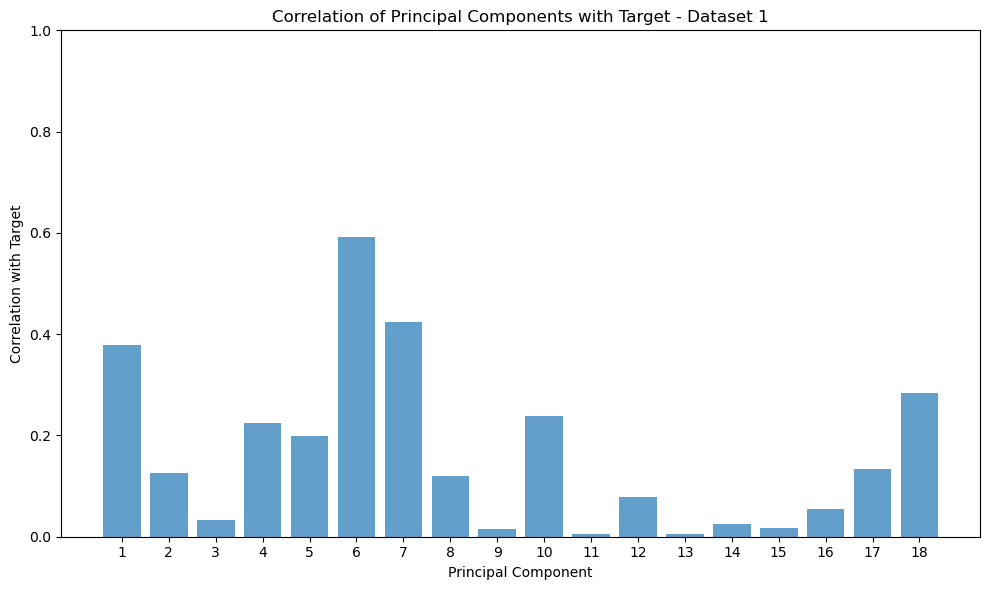

In [12]:
i = 1
#for file in file_path:
file = file_path[1]
df = pd.read_csv(file)
X = df[not_non_features].values 
y = df[target].values  
sc = StandardScaler()
X_std = sc.fit_transform(X)

pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_std)
n_pcs = pca.n_components_
explained_variance_ratio = pca.explained_variance_ratio_

correlations = np.array([np.corrcoef(X_pca[:, i], y)[0, 1] for i in range(n_pcs)])
components = pca.components_
feature_contributions = pd.DataFrame(components, columns=not_non_features)
feature_contributions.index = [f"PC{i+1}" for i in range(n_pcs)]
explained_variance_list = [
    f"PC{i+1}: {explained_variance_ratio[i]:.4f}" for i in range(n_pcs)
]
correlation_list = [
    f"PC{i+1}: {correlations[i]:.4f}" for i in range(n_pcs)
]
top_features_list = []
for j in range(n_pcs):
    top_features = feature_contributions.iloc[j].abs().nlargest(4).index.tolist()
    top_features_list.append(f"PC{j+1}: {', '.join(top_features)}")

markdown_output = f"""
## Dataset {i}

### Principal Components:
- Number of principal components: **{n_pcs}**

### Explained Variance:
{', '.join(explained_variance_list)}

### Correlation of Principal Components with Target:
{', '.join(correlation_list)}

### Top 3-4 Feature Contributions for Each Principal Component:
{chr(10).join(top_features_list)}  


---

"""
print(markdown_output)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_pcs + 1), np.abs(correlations), alpha=0.7, align='center')
plt.xticks(range(1, n_pcs + 1), range(1, n_pcs + 1)) 
plt.ylim(0, 1)  
plt.ylabel('Correlation with Target')
plt.xlabel('Principal Component')
plt.title(f'Correlation of Principal Components with Target - Dataset {i}')
plt.tight_layout()
plt.show()

i += 1


#### via PLS Regression

PLS projects the data into a lower-dimensional space while maximizing the covariance between the predictors (features) and the response (target variable).

Standardization: We standardize the feature data using StandardScaler.

PLS Regression: We create a PLSRegression object and fit it to the standardized features and the target variable. The number of components is limited to the minimum of the number of features or a specified maximum (in this case, 10).

Scores: The x_scores_ attribute gives the transformed features, which can be useful for further analysis.

Explained Variance: The explained variance ratio for the PLS components is calculated using the score method.

Loadings: The loadings represent the importance of each original feature in the PLS components.

In [9]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_Supervised/'

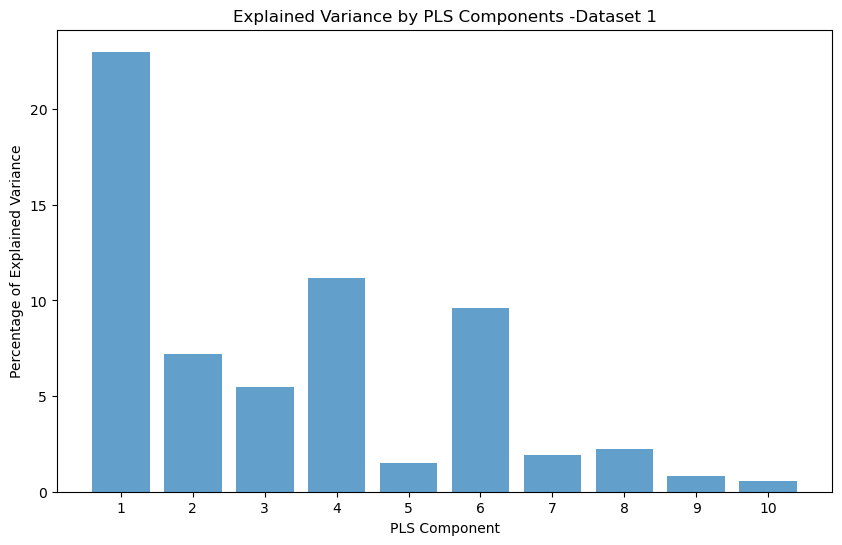

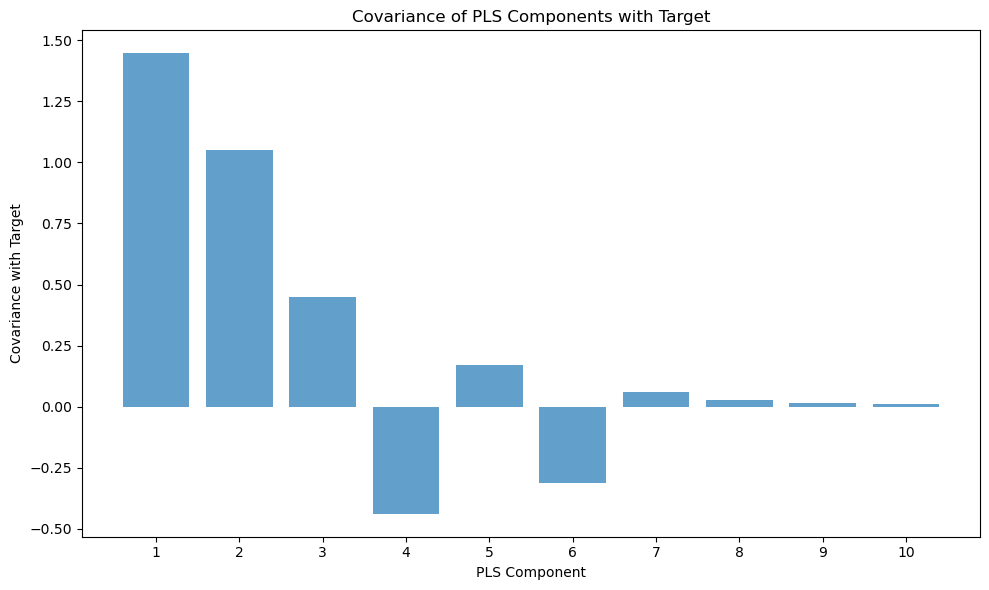

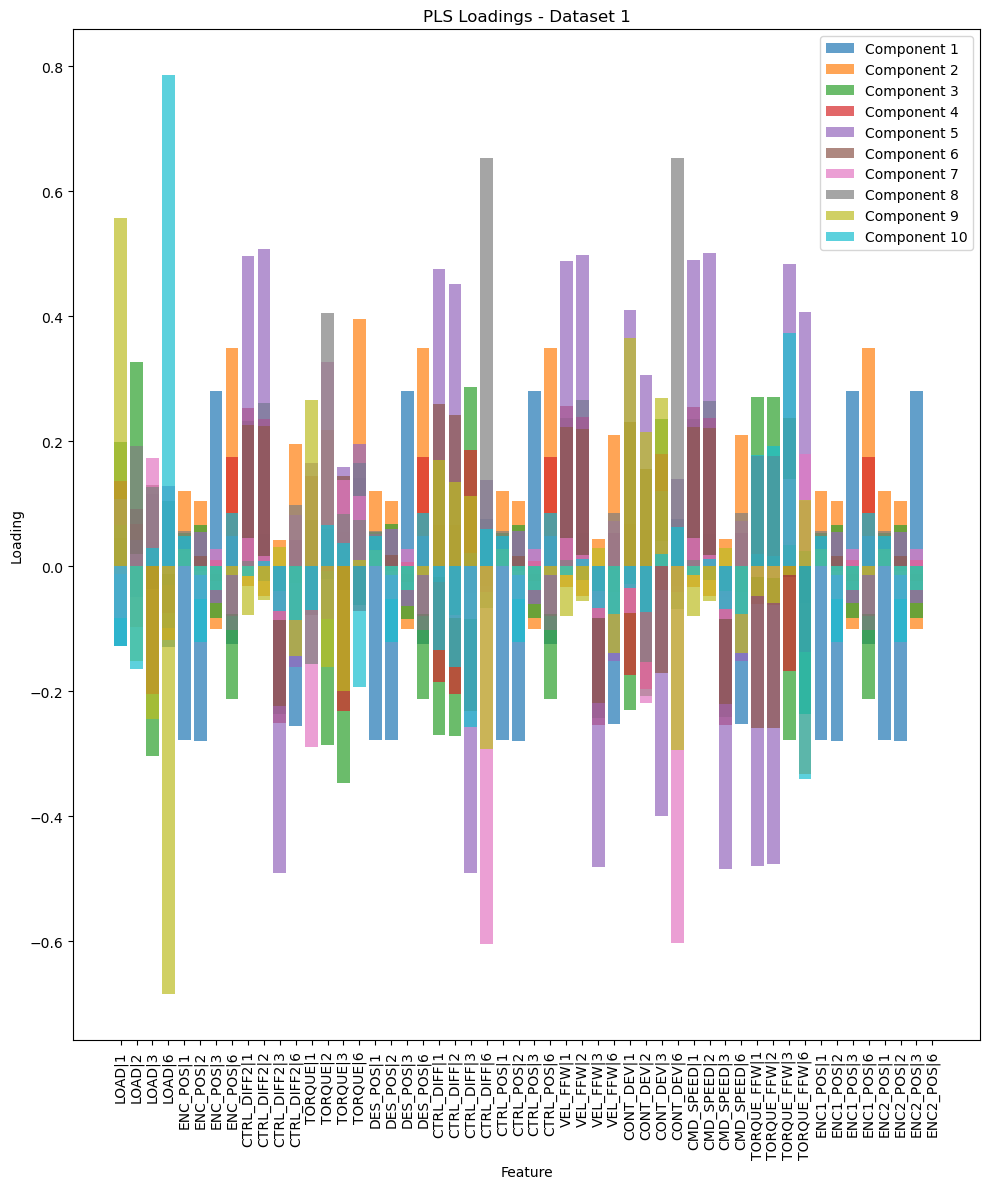

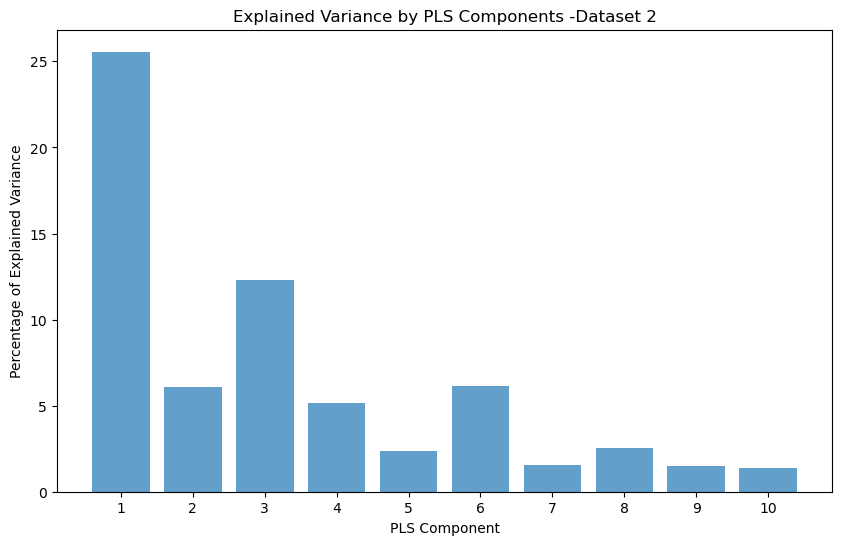

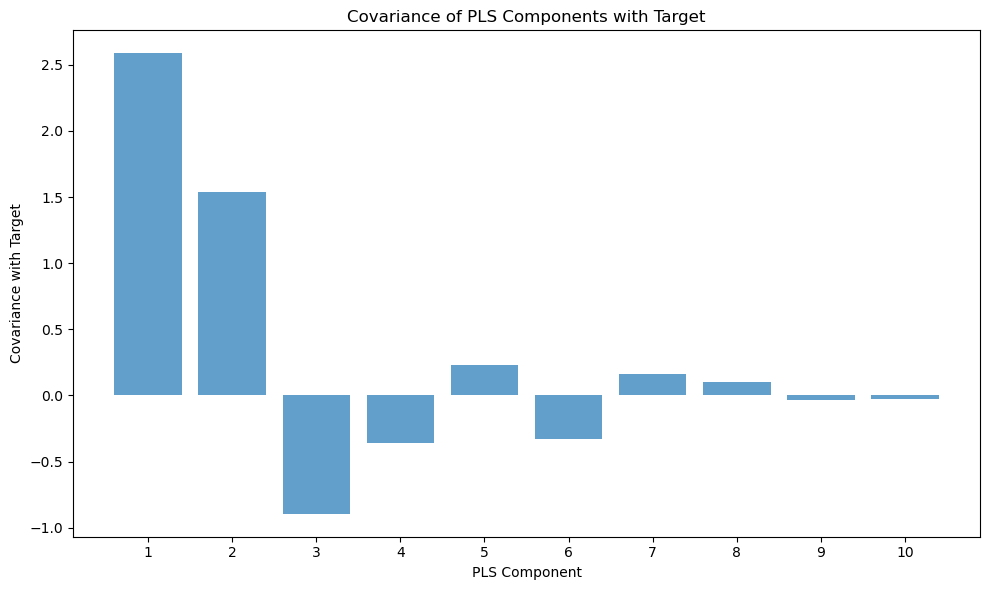

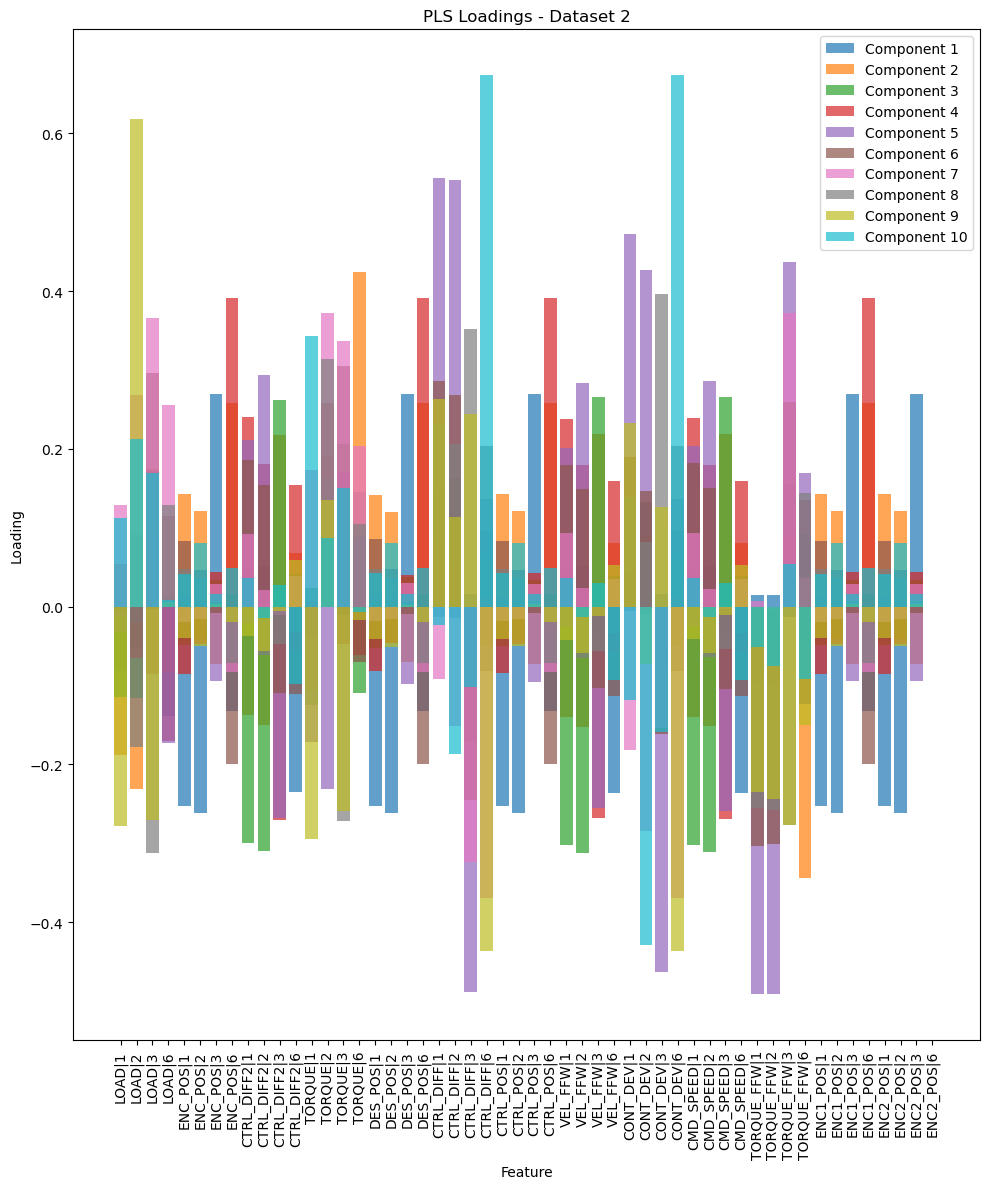

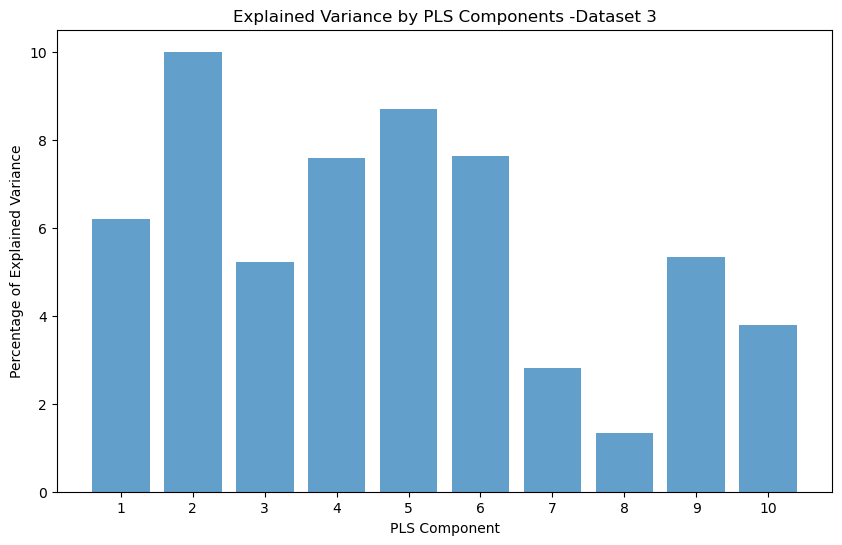

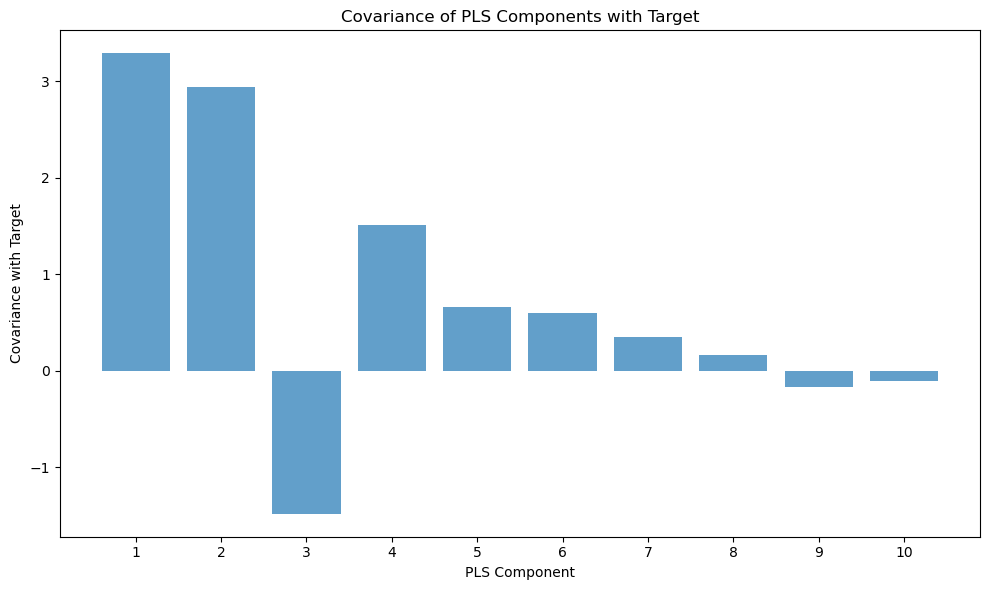

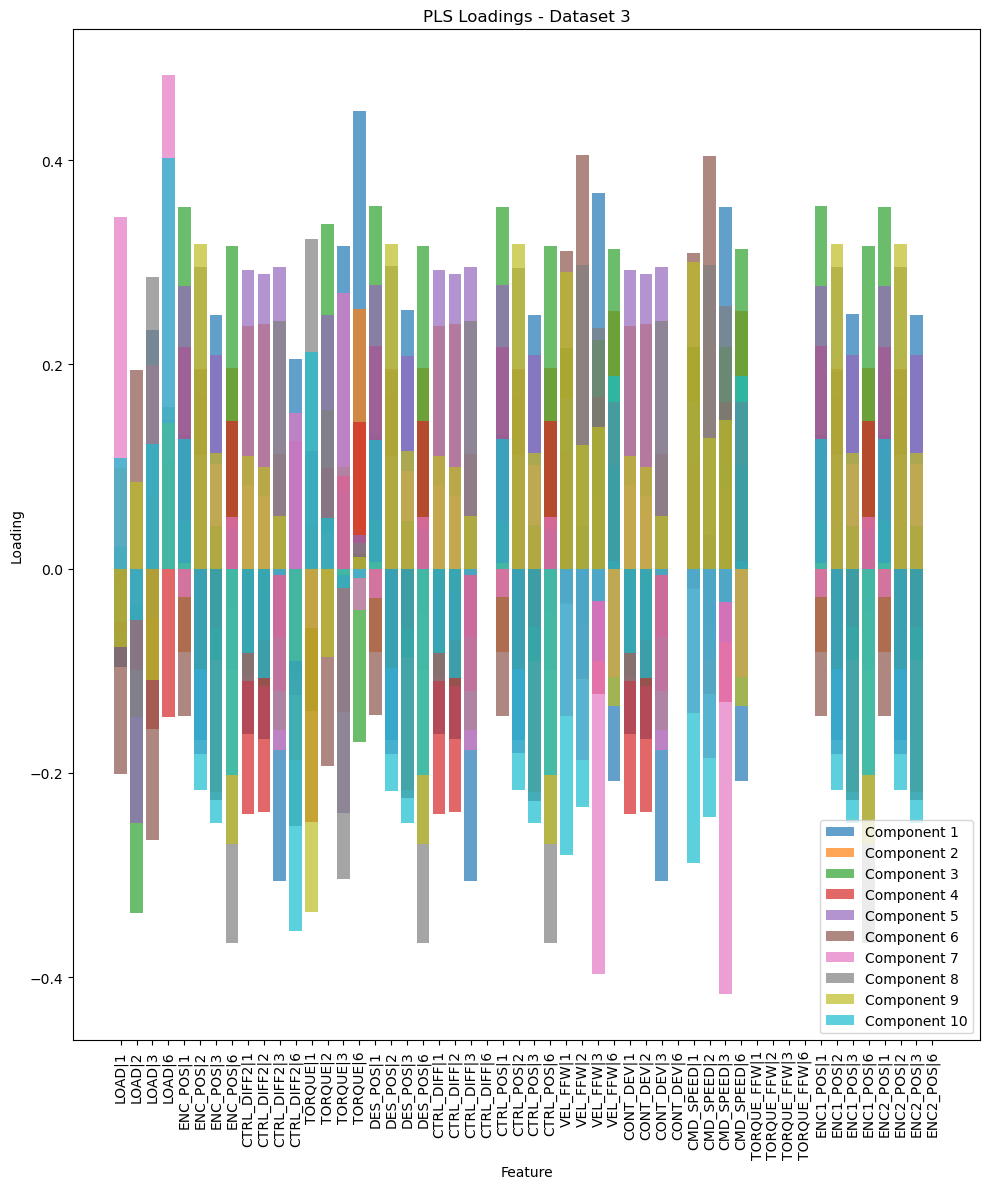

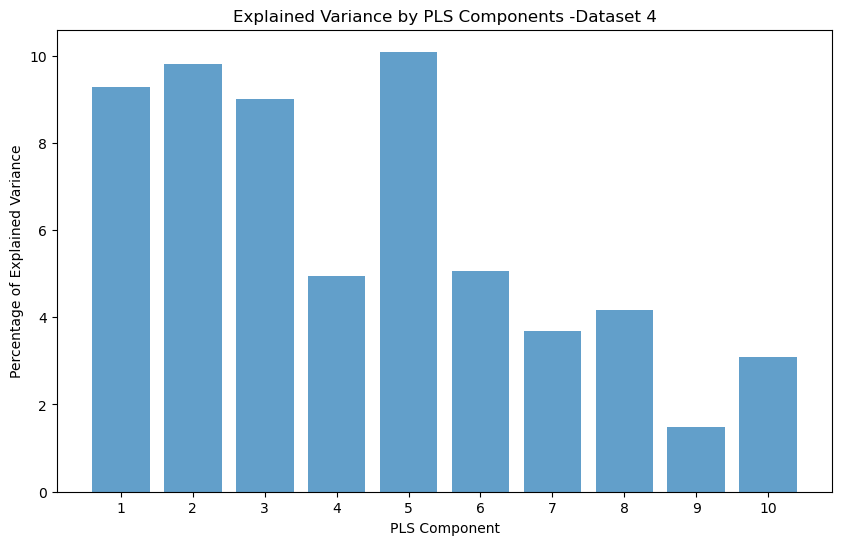

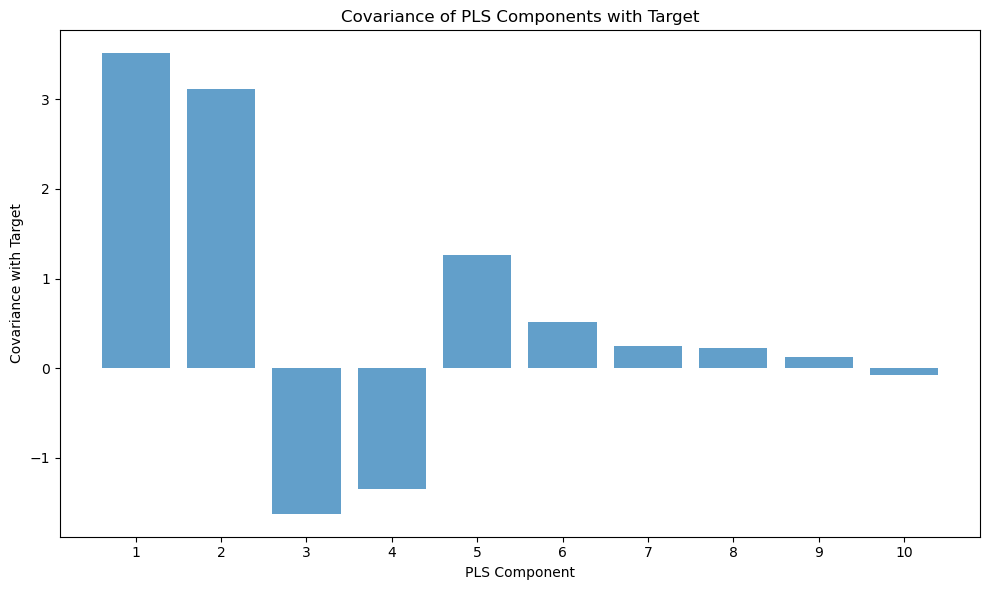

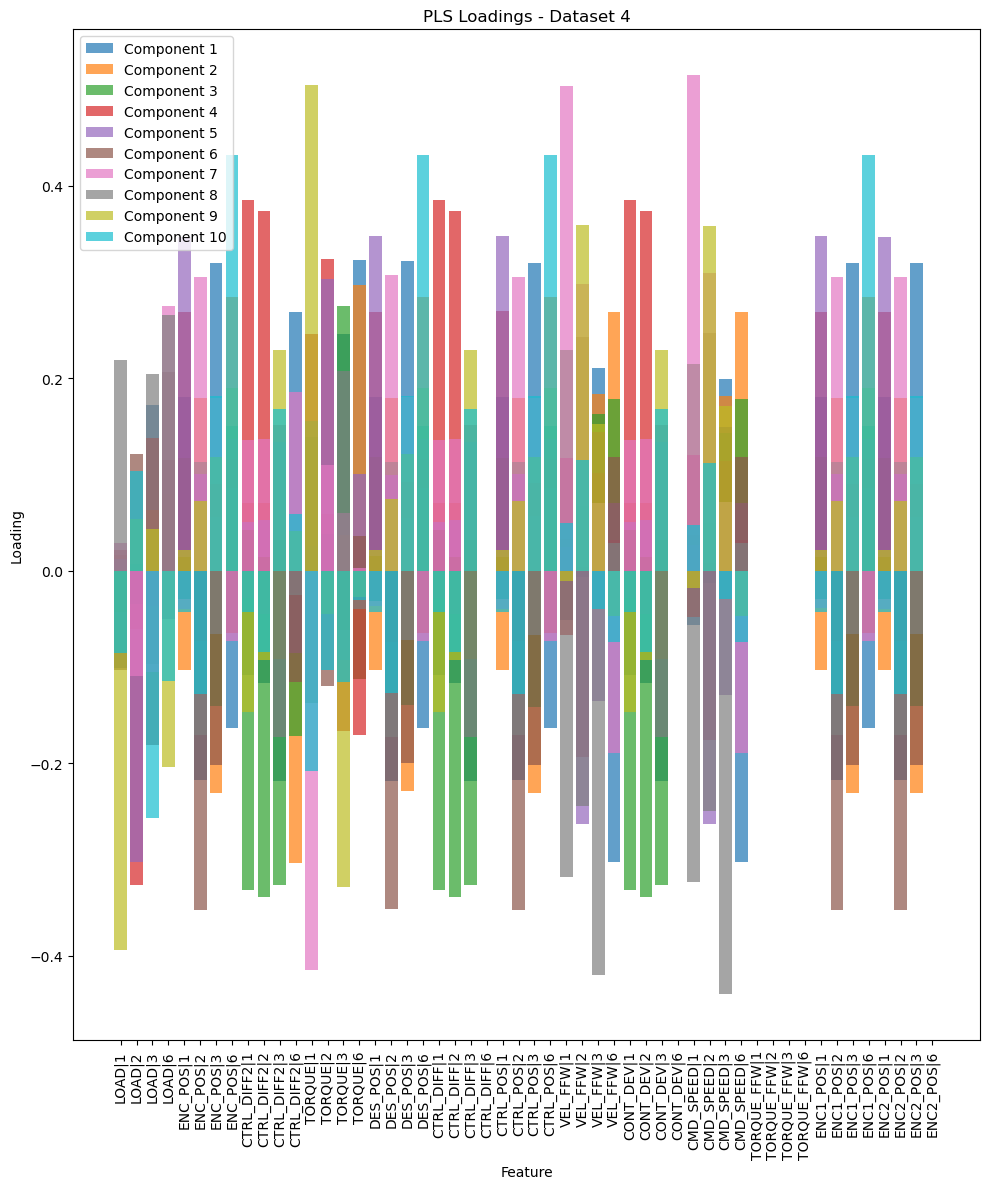

In [13]:
from sklearn.cross_decomposition import PLSRegression

k = 1
for file in file_path:
    #file = file_path[1]
    df = pd.read_csv(file)
    X = df[not_non_features].values 
    y = df[target].values
    sc = StandardScaler()
    X_std = sc.fit_transform(X)

    n_components = min(X_std.shape[1], 10)  
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_std, y)[0]
    explained_variance = np.var(X_pls, axis=0) / np.var(X_std, axis=0).sum()

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), explained_variance * 100, alpha=0.7, align='center')
    plt.xticks(range(1, n_components + 1), range(1, n_components + 1))
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('PLS Component')
    plt.title(f'Explained Variance by PLS Components -Dataset {k}')
    plt.show()

    covariance = [np.cov(X_pls[:, i], y)[0, 1] for i in range(n_components)]
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), covariance, alpha=0.7, align='center')
    plt.xticks(range(1, n_components + 1), range(1, n_components + 1)) 
    plt.ylabel('Covariance with Target')
    plt.xlabel('PLS Component')
    plt.title('Covariance of PLS Components with Target')
    plt.tight_layout()
    plt.show()

    loadings = pls.x_loadings_
    loadings_df = pd.DataFrame(loadings, 
                                columns=[f'Component {j + 1}' for j in range(n_components)],
                                index=not_non_features)  
    explained_variance_list = [
        f"Component {i + 1}: {explained_variance[i]:.4f}" for i in range(n_components)
    ]
    top_features_list = []
    for j in range(n_components):
        top_features = loadings_df.iloc[:, j].abs().nlargest(4).index.tolist()
        top_features_list.append(f"{', '.join(top_features)}")

    pls_reg_df = pd.DataFrame({
        'Principal Component': [f"PC{i+1}" for i in range(n_components)],
        'Explained Variance': explained_variance,
        'Top Features': top_features_list
    })
    name = os.path.join(output_folder, f"PC_{os.path.basename(file)}.csv")
    pls_reg_df.to_csv(name, index=False)

    '''markdown_output = f"""
    ## Dataset {i}

    ### PLS Components:
    - Number of PLS components: **{n_components}**

    ### Explained Variance:
    {', '.join(explained_variance_list)}

    ### Top 3-4 Feature Contributions for Each Component:
    {chr(10).join(top_features_list)}

    ### Loadings (Feature Importance):
    {loadings_df.to_string()}

    ---

    """
    print(markdown_output)'''

    plt.figure(figsize=(10, 12))  
    for j in range(n_components):
        plt.bar(not_non_features, loadings[:, j], alpha=0.7, label=f'Component {j + 1}')

    plt.ylabel('Loading')
    plt.xlabel('Feature')
    plt.title(f'PLS Loadings - Dataset {k}')
    plt.xticks(rotation=90) 
    plt.legend()
    plt.tight_layout()
    plt.show()

    k += 1


LSTM on PCs

In [14]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_LSTM_Supervised'
input_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_Supervised'
result_df = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Train_RMSE', 'Test_R2', 'Test_RMSE'])
filenamefinal = os.path.join(output_folder, f'result_lstm_pca1-4_7030.csv')

In [15]:
i = 1
for file in file_path:
        df = pd.read_csv(file)
        pca_info = pd.read_csv(os.path.join(input_folder, f"PC_{os.path.basename(file)}.csv"))
        top_features_list = []
        for i in range(4):
                top_features_pc = pca_info.loc[i, 'Top Features'].split(', ')
                top_features_list.extend(top_features_pc)
        top_features_list = list(set(top_features_list))
        #top_features_list = pca_info.loc[3, 'Top Features'].split(', ')
        print(top_features_list)
        X = df[top_features_list]
        y = df[[target]]
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        scaled_X = scaler_X.fit_transform(X)
        scaled_y = scaler_y.fit_transform(y)

        train_size = int(len(scaled_X) * 0.7)
        test_size = len(scaled_X) - train_size
        X_train, X_test = scaled_X[:train_size], scaled_X[train_size:]
        y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

        time_step = 60
        X_train, y_train = create_dataset(X_train, y_train, time_step)
        X_test, y_test = create_dataset(X_test, y_test, time_step)

        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model(input_shape)

        # Train the model
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # Make Predictions
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        # Inverse transform predictions
        train_predict_inv = scaler_y.inverse_transform(train_predict)
        y_train_inv = scaler_y.inverse_transform(y_train)
        test_predict_inv = scaler_y.inverse_transform(test_predict)
        y_test_inv = scaler_y.inverse_transform(y_test)

        '''train_df = pd.DataFrame({
                'Train_y': y_train_inv.flatten(),
                'Train_pred_y': train_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}_7030.csv')
        train_df.to_csv(filename, index=False)

        test_df = pd.DataFrame({
                'Test_y': y_test_inv.flatten(),
                'Test_pred_y': test_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}_7030.csv')
        test_df.to_csv(filename, index=False)'''

        # Calculate R2 and RMSE
        train_r2 = r2_score(y_train_inv, train_predict_inv)
        test_r2 = r2_score(y_test_inv, test_predict_inv)
        train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
        test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

        # Append the results to the dataframe
        result_df = result_df.append({
        'Dataset': os.path.basename(file),
        'Train_R2': train_r2,
        'Train_RMSE': train_rmse,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse
        }, ignore_index=True)

        result_df.to_csv(filenamefinal, index=False)
        i=i+1

['LOAD|3', 'ENC_POS|6', 'ENC2_POS|3', 'CTRL_DIFF|3', 'CTRL_POS|6', 'ENC1_POS|6', 'LOAD|2', 'TORQUE|3', 'CMD_SPEED|1', 'VEL_FFW|1', 'ENC1_POS|3', 'VEL_FFW|3', 'ENC_POS|3', 'CMD_SPEED|3', 'TORQUE|6', 'CTRL_POS|3']


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 2/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 1.0775e-04 - val_loss: 0.0083
Epoch 3/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 6.9352e-05 - val_loss: 0.0033
Epoch 4/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - loss: 6.2601e-05 - val_loss: 0.0039
Epoch 5/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 76s 46ms/step - loss: 5.3693e-05 - val_loss: 0.0051
Epoch 6/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - loss: 5.2131e-05 - val_loss: 0.0038
Epoch 7/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 4.5798e-05 - val_loss: 0.0039
Epoch 8/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - loss: 4.6737e-05 - val_loss: 0.0035
Epoch 9/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 68s 41ms/step - loss: 4.9164e-05 - val_loss: 0.0018
Epoch 10/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 3.3600e-05 - val_loss: 0.0019
Epoch 11/30
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 70s 43ms/step - loss

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - loss: 0.0060 - val_loss: 5.0565e-04
Epoch 2/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - loss: 1.3806e-04 - val_loss: 0.0028
Epoch 3/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 1.4337e-04 - val_loss: 0.0030
Epoch 4/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 1.2956e-04 - val_loss: 0.0078
Epoch 5/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1114e-04 - val_loss: 0.0063
Epoch 6/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 9.5950e-05 - val_loss: 0.0012
Epoch 7/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 9.4119e-05 - val_loss: 0.0014
Epoch 8/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 4.3148e-05 - val_loss: 0.0012
Epoch 9/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 2.6346e-05 - val_loss: 8.6383e-04
Epoch 10/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 2.9491e-05 - val_loss: 7.3517e-04
Epoch 11/30
993/993 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - loss: 2.0608e-

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 65s 45ms/step - loss: 0.0035 - val_loss: 1.8475e-04
Epoch 2/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - loss: 1.0397e-04 - val_loss: 1.3397e-04
Epoch 3/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - loss: 4.6870e-05 - val_loss: 1.7578e-04
Epoch 4/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - loss: 5.2948e-05 - val_loss: 1.3670e-04
Epoch 5/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - loss: 2.7356e-05 - val_loss: 3.9098e-05
Epoch 6/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - loss: 2.9721e-05 - val_loss: 4.7448e-05
Epoch 7/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 59s 42ms/step - loss: 2.6399e-05 - val_loss: 1.4227e-04
Epoch 8/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - loss: 2.7357e-05 - val_loss: 3.5630e-05
Epoch 9/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - loss: 1.5144e-05 - val_loss: 3.4265e-05
Epoch 10/30
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - loss: 1.0771e-05 - val_loss: 4.6514e-05
Epoch 11/30
1406/1406 ━

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


918/918 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 0.0028 - val_loss: 3.3817e-04
Epoch 2/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 1.5800e-04 - val_loss: 2.5804e-04
Epoch 3/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 8.3416e-05 - val_loss: 1.9282e-04
Epoch 4/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - loss: 6.1655e-05 - val_loss: 8.4776e-05
Epoch 5/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - loss: 4.5567e-05 - val_loss: 1.2690e-04
Epoch 6/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 3.0662e-05 - val_loss: 5.0021e-05
Epoch 7/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - loss: 3.6808e-05 - val_loss: 6.3984e-05
Epoch 8/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 2.1167e-05 - val_loss: 5.9348e-05
Epoch 9/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - loss: 1.5775e-05 - val_loss: 5.4936e-05
Epoch 10/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 1.7418e-05 - val_loss: 5.5067e-05
Epoch 11/30
918/918 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step

## Scaling

In [5]:
def scale_data(df):
    X = df[not_non_features]
    y = df[[target]]
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaled_X = scaler_X.fit_transform(X)
    scaled_y = scaler_y.fit_transform(y)

    return scaler_X, scaler_y, scaled_X, scaled_y

In [6]:
def descale_data(train_predict, y_train, test_predict, y_test, scaler_y):
    train_predict_inv = scaler_y.inverse_transform(train_predict)
    y_train_inv = scaler_y.inverse_transform(y_train)
    test_predict_inv = scaler_y.inverse_transform(test_predict)
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    return train_predict_inv, y_train_inv, test_predict_inv, y_test_inv

## PCA2

In [16]:
def create_dataframes(text1, text2, y, y_predict):
    df = pd.DataFrame({
            text1: y.flatten(),
            text2: y_predict.flatten() })
    
    return df

In [13]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/PCA_LSTM/'
filenamepca = os.path.join(output_folder, f'result_summary_pca_lstm.csv')
result_pca = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Train_RMSE', 'Test_R2', 'Test_RMSE'])

In [21]:
for file in file_path[1:]:
    df = pd.read_csv(file)
    scaler_X, scaler_y, scaled_X, scaled_y = scale_data(df)
    print(scaled_X.shape)
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(scaled_X)
    print(X_pca.shape)

    train_size = int(len(X_pca) * 0.2)
    test_size = len(X_pca) - train_size
    X_train, X_test = X_pca[:train_size], X_pca[train_size:]
    y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

    time_step = 60
    X_train, y_train = create_dataset(X_train, y_train, time_step)
    X_test, y_test = create_dataset(X_test, y_test, time_step)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Make Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict_inv, y_train_inv, test_predict_inv, y_test_inv = descale_data(train_predict, y_train, test_predict, y_test, scaler_y)

    train_df = create_dataframes('Train_y', 'Train_pred_y', y_train_inv.flatten(), train_predict_inv.flatten())
    filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}.csv')
    train_df.to_csv(filename, index=False)
    

    test_df = create_dataframes('Test_y', 'Test_pred_y', y_test_inv.flatten(), test_predict_inv.flatten())
    filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}.csv')
    test_df.to_csv(filename, index=False)

    # Calculate R2 and RMSE
    train_r2 = r2_score(y_train_inv, train_predict_inv)
    test_r2 = r2_score(y_test_inv, test_predict_inv)
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

    # Append the results to the dataframe
    result_pca = result_pca.append({
    'Dataset': os.path.basename(file),
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
    }, ignore_index=True)

    result_pca.to_csv(filenamepca, index=False)

(45468, 52)
(45468, 10)
Epoch 1/50


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - loss: 0.0116 - val_loss: 0.1965
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 1.5630e-05 - val_loss: 0.2036
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 1.0657e-05 - val_loss: 0.2114
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 7.4863e-06 - val_loss: 0.2192
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - loss: 5.5160e-06 - val_loss: 0.2264
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - loss: 4.0823e-06 - val_loss: 0.2309
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 5.4065e-06 - val_loss: 0.2338
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 4.0143e-06 - val_loss: 0.2350
Epoch 9/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 7.8938e-06 - val_loss: 0.2322
Epoch 10/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 7.2496e-06 - val_loss: 0.2310
Epoch 11/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 6.3334e-06 - val_loss: 0.2329
E

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


401/401 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - loss: 0.0119 - val_loss: 0.3177
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - loss: 7.5454e-05 - val_loss: 0.3150
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - loss: 5.2591e-05 - val_loss: 0.3121
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 6.4802e-05 - val_loss: 0.3098
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 4.1974e-05 - val_loss: 0.3068
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 4.2968e-05 - val_loss: 0.3056
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - loss: 5.1471e-05 - val_loss: 0.3007
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - loss: 3.4864e-05 - val_loss: 0.2996
Epoch 9/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - loss: 3.6826e-05 - val_loss: 0.2948
Epoch 10/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - loss: 2.7241e-05 - val_loss: 0.2899
Epoch 11/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - loss: 2.1709e-05 - val_loss: 0.2841
E

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - loss: 0.0249 - val_loss: 0.2985
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 3.0426e-04 - val_loss: 0.3020
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - loss: 1.6650e-04 - val_loss: 0.2999
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 1.2509e-04 - val_loss: 0.2985
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 1.2532e-04 - val_loss: 0.2976
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - loss: 1.2483e-04 - val_loss: 0.3027
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - loss: 1.3384e-04 - val_loss: 0.3006
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - loss: 8.2037e-05 - val_loss: 0.2999
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 1.1119e-04 - val_loss: 0.3032
Epoch 10/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - loss: 8.9408e-05 - val_loss: 0.3083
Epoch 11/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - loss: 8.5604e-05 - val_loss: 0.3081
E

## Statistics

In [4]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/new_dataset/abs'


In [33]:
lags = [100, 500, 1000]
threshold_factor = [1, 0.5, 2]
influence = [0, 0.5, 1]
split_info = [0.5, 0.3, 0.2]

In [36]:
results_df = pd.DataFrame(columns=['file', 'len(df)', 'abs_mean', 'no_of_peaks>mean', 'abs_two_times_mean', 'no_of_peaks>2mean'])
i = 0
for file in file_path:
    df = pd.read_csv(file)
    df = df[[target]]

    for sp in split_info:
        train_size = int(len(df) * sp)
        X = df[:train_size]
        abs_df = X.abs()
        abs_mean = abs_df.mean().iloc[0].round(3)

        abs_no_of_peaks_1x = (abs_df > abs_mean).sum().iloc[0]
        abs_two_times_mean = 2 * abs_mean
        abs_no_of_peaks_2x = (abs_df > 2 * abs_mean).sum().iloc[0]
        #print(mean_df)
        results = pd.DataFrame([{
            'file': os.path.basename(file) + str(sp),
            'len(df)': len(X),
            'abs_mean': abs_mean,
            'no_of_peaks>mean': abs_no_of_peaks_1x,
            'abs_two_times_mean': abs_two_times_mean,
            'no_of_peaks>2mean': abs_no_of_peaks_2x
        }])
        results_df = pd.concat([results_df,results], ignore_index=True)


        for lag_val in lags:
            print("Lag : ", lag_val)
            for inf in influence:
                for t in threshold_factor:
                    peak_info = get_peak_indices_by_column(abs_df, lag_val, inf, t)

                    for column_name, peak_indices in peak_info.items():
                        num_peaks_column = f'Num_Peaks_Lag{lag_val}_Inf{inf}_Th{t}'
                        if num_peaks_column not in results_df.columns:
                            results_df[num_peaks_column] = np.nan
                        results_df.at[results_df.index[i], num_peaks_column] = len(peak_indices)
        i = i+1
        #final_df = pd.concat([final_df, mean_df])
        results_df.to_csv(os.path.join(output_folder,'Peaks_Target.csv'), index=False)


Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000
Lag :  100


/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lag :  500
Lag :  1000


## LSTM

In [7]:
def create_dataset(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [8]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

## Global Model LSTM

In [6]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Global/'

#result_df = pd.DataFrame(columns=['Dataset', 'Train_R2_5050', 'Train_RMSE_5050', 'Test_R2_5050', 'Test_RMSE_5050'])
result_df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Global/result_summary_lstm_global1.csv')
filenamefinal = os.path.join(output_folder, f'result_summary_lstm_global1.csv')


In [7]:
for file in file_path[2:]:
        df = pd.read_csv(file)
        X = df[not_non_features]
        y = df[[target]]
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        scaled_X = scaler_X.fit_transform(X)
        scaled_y = scaler_y.fit_transform(y)

        train_size = int(len(scaled_X) * 0.2)
        test_size = len(scaled_X) - train_size
        X_train, X_test = scaled_X[:train_size], scaled_X[train_size:]
        y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

        time_step = 60
        X_train, y_train = create_dataset(X_train, y_train, time_step)
        X_test, y_test = create_dataset(X_test, y_test, time_step)

        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model(input_shape)

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # Make Predictions
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        # Inverse transform predictions
        train_predict_inv = scaler_y.inverse_transform(train_predict)
        y_train_inv = scaler_y.inverse_transform(y_train)
        test_predict_inv = scaler_y.inverse_transform(test_predict)
        y_test_inv = scaler_y.inverse_transform(y_test)

        train_df = pd.DataFrame({
                'Train_y': y_train_inv.flatten(),
                'Train_pred_y': train_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}_5050.csv')
        train_df.to_csv(filename, index=False)

        test_df = pd.DataFrame({
                'Test_y': y_test_inv.flatten(),
                'Test_pred_y': test_predict_inv.flatten() })
        filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}_5050.csv')
        test_df.to_csv(filename, index=False)

        # Calculate R2 and RMSE
        train_r2 = r2_score(y_train_inv, train_predict_inv)
        test_r2 = r2_score(y_test_inv, test_predict_inv)
        train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
        test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

        # Append the results to the dataframe
        result_df = result_df.append({
        'Dataset': os.path.basename(file),
        'Train_R2_5050': train_r2,
        'Train_RMSE_5050': train_rmse,
        'Test_R2_5050': test_r2,
        'Test_RMSE_5050': test_rmse
        }, ignore_index=True)

        result_df.to_csv(filenamefinal, index=False)

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - loss: 0.0108 - val_loss: 0.0014
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 9.6216e-05 - val_loss: 0.0014
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - loss: 6.6483e-05 - val_loss: 0.0017
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - loss: 5.5175e-05 - val_loss: 0.0017
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - loss: 5.6817e-05 - val_loss: 0.0021
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 3.2322e-05 - val_loss: 0.0020
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - loss: 3.7066e-05 - val_loss: 0.0024
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - loss: 2.9532e-05 - val_loss: 0.0029
Epoch 9/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - loss: 2.3157e-05 - val_loss: 0.0020
Epoch 10/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 3.4766e-05 - val_loss: 0.0027
Epoch 11/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - loss: 1.5852e-05 - val_los

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 0.0123 - val_loss: 0.0013
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - loss: 1.3312e-04 - val_loss: 0.0020
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 1.1089e-04 - val_loss: 0.0019
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 7.5076e-05 - val_loss: 0.0020
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 5.9120e-05 - val_loss: 0.0019
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 6.2493e-05 - val_loss: 0.0018
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - loss: 5.1841e-05 - val_loss: 0.0018
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 5.7961e-05 - val_loss: 0.0018
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 5.2972e-05 - val_loss: 0.0022
Epoch 10/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 6.2784e-05 - val_loss: 0.0016
Epoch 11/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 4.0694e-05 - val_loss: 0.0018
E

In [38]:
for i in range(4):
    file=file_path[i]
    df = pd.read_csv(file)
    print(len(df))

74822
45468
64337
42016


## Global Model RF

In [10]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Global RF/'

result_df = pd.DataFrame(columns=['Dataset', 'Train_R2_5050', 'Train_RMSE_5050', 'Test_R2_5050', 'Test_RMSE_5050'])
#result_df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Global/result_summary_lstm_global1.csv')


In [14]:
print(train_pred)

[ 0.          0.          0.         ... -0.67552254 -0.6768922
 -0.67914765]


In [15]:
print(y_train)

       CURRENT|6
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
...          ...
37406  -0.668701
37407  -0.671387
37408  -0.676758
37409  -0.676758
37410  -0.679443

[37411 rows x 1 columns]


In [17]:
for file in file_path:
        filenamefinal = os.path.join(output_folder, f'result_summary_rf_global2.csv')
        split_ratio = 0.3
        df = pd.read_csv(file)
        X = df[not_non_features]
        y = df[[target]]
        rf_model = RandomForestRegressor()
        #fit_predict_rf(rf_model, X, y, split_ratio, file)
        train_size = int(len(X) * split_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        rf_model.fit(X_train, y_train)
        train_pred = rf_model.predict(X_train)
        test_pred = rf_model.predict(X_test)
        #print(y_pred)
        y_train = y_train.squeeze()
        y_test = y_test.squeeze()

        train_df = pd.DataFrame({
                'Train_y': y_train,
                'Train_pred_y': train_pred })
        filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}_3070.csv')
        train_df.to_csv(filename, index=False)

        test_df = pd.DataFrame({
                'Test_y': y_test,
                'Test_pred_y': test_pred })
        filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}_3070.csv')
        test_df.to_csv(filename, index=False)
        
        train_mse = mean_squared_error(y_train, train_pred)
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, test_pred)

        result_df = result_df.append({
                'Dataset': os.path.basename(file),
                'Train_R2_3070': train_r2,
                'Train_RMSE_3070': train_rmse,
                'Test_R2_3070': test_r2,
                'Test_RMSE_3070': test_rmse
                }, ignore_index=True)

        result_df.to_csv(filenamefinal, index=False)
        print("Done")


/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done


/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done


/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done


/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done


## Peak Detection Simple

In [6]:
def peak_finding(data, window_size):
    data_extended = np.concatenate([np.zeros(window_size),data,np.zeros(window_size)])
    max_list = []
        
    for i, value in enumerate(data_extended):
        if (i >= window_size) and (i < len(data_extended)-window_size):
            try:
                max_left = data_extended[(i-window_size):i+1].max()
                max_right = data_extended[i:(i+window_size)+1].max()
                chek_value = data_extended[i] - ((max_left+max_right)/2)
            except ValueError:
                 pass
                
            if (chek_value >=0):
                max_list.append((i-window_size, data[(i-window_size)]))
    return max_list

In [7]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_Simple/'
window_size = [1000,5000,10000]

In [8]:
def get_peak_indices_by_column(dataframe, window_size):
    peak_indices_by_column = {}

    for column_name in dataframe.columns:
        result = peak_finding(dataframe[column_name], window_size)
        result = [t[0] for t in result]
        peak_indices_by_column[column_name] = result

    return peak_indices_by_column

In [9]:
import itertools

def find_common_peaks(peaks_df):
    common_peaks = []
    
    columns = peaks_df['Column_Name'].tolist()
    columns.remove(target)
    column_combinations = [(column, target) for column in columns]   

    for pair in column_combinations:
        column1_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[0], 'Peak_Indices'].iloc[0])
        column2_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[1], 'Peak_Indices'].iloc[0])
        
        common_indices = list(column1_peaks.intersection(column2_peaks))
        num_common_peaks = len(common_indices)
        
        common_peaks.append({'feature_pair': pair, 'peak_indices': common_indices, 'num_peaks': num_common_peaks, 'window_size':peaks_df['Window_Size'].iloc[0]})
    
    return pd.DataFrame(common_peaks)

In [10]:
def get_output_peaks(df, window_size):  
    peak_info = get_peak_indices_by_column(df, window_size)
    peaks_df = pd.DataFrame({'Column_Name': list(peak_info.keys()), 
                                'Peak_Indices': peak_info.values()})
    peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
    peaks_df['Window_Size'] = window_size
    common_peaks_df = find_common_peaks(peaks_df)

    return common_peaks_df


In [37]:
for i in range(4):
    file=file_path[i]
    df = pd.read_csv(file)
    X = df[not_non_features]
    y = df[[target]]
    X.loc[:,'CURRENT|6'] = y
    df_p = pd.DataFrame()
    for w in window_size:
        com_pk_df = get_output_peaks(X, w)
        df_p = df_p.append(com_pk_df)

    filename = os.path.join(output_folder, f'{os.path.basename(file)}_common_peaks.csv')
    df_p.to_csv(filename, index=False)

/usr/lib64/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/lib64/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [11]:
peak_info_list = ['/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_Simple/RS_Energie_V_AL_2007.csv_common_peaks.csv',
                  '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_Simple/RS_Energie_V_S235JR.csv_common_peaks.csv',
                  '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_Simple/AL_RS_Energie.csv_common_peaks.csv',
                  '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_Simple/S_RS_Energie.csv_common_peaks.csv']

In [34]:
peak_info = pd.read_csv(peak_info_list[1])
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]
print(max_peaks)

                   feature_pair  \
51  ('ENC2_POS|6', 'CURRENT|6')   

                                         peak_indices  num_peaks  window_size  
51  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...       1587         1000  


In [23]:
column_name = eval(max_peaks['feature_pair'].iloc[0])[0]
window_size = max_peaks['window_size'].iloc[0]
print(column_name, window_size)

ENC2_POS|6 1000


In [12]:
def create_train_test_split(X_train, y_train, X_test, y_test, column_name, window_size):
    result = peak_finding(X_train[column_name], window_size)
    peak_indices_train = [t[0] for t in result]
    print("Train:", len(peak_indices_train))

    X_train_peak = X_train.loc[peak_indices_train]
    y_train_peak = y_train.loc[peak_indices_train]
    X_train_non_peak = X_train.drop(peak_indices_train)
    y_train_non_peak = y_train.drop(peak_indices_train)

    #Find peaks and non-peaks in test data
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    result = peak_finding(X_test[column_name], window_size)
    peak_indices_test = [t[0] for t in result]
    print("Test:", len(peak_indices_test))

    X_test_peak = X_test.loc[peak_indices_test]
    y_test_peak = y_test.loc[peak_indices_test]
    X_test_non_peak = X_test.drop(peak_indices_test)
    y_test_non_peak = y_test.drop(peak_indices_test)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

In [40]:
df = pd.read_csv(file_path[3])
X = df[not_non_features]
y = df[[target]]
print(len(peak_finding(X['ENC2_POS|6'],1000)))
train_size = int(len(X) * 0.5)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

42016


In [ ]:
74822
45468
64337
42016

In [28]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, column_name, window_size)

Train: 37411
Test: 37411


In [26]:
print(X_train_non_peak)

Empty DataFrame
Columns: [LOAD|1, LOAD|2, LOAD|3, LOAD|6, ENC_POS|1, ENC_POS|2, ENC_POS|3, ENC_POS|6, CTRL_DIFF2|1, CTRL_DIFF2|2, CTRL_DIFF2|3, CTRL_DIFF2|6, TORQUE|1, TORQUE|2, TORQUE|3, TORQUE|6, DES_POS|1, DES_POS|2, DES_POS|3, DES_POS|6, CTRL_DIFF|1, CTRL_DIFF|2, CTRL_DIFF|3, CTRL_DIFF|6, CTRL_POS|1, CTRL_POS|2, CTRL_POS|3, CTRL_POS|6, VEL_FFW|1, VEL_FFW|2, VEL_FFW|3, VEL_FFW|6, CONT_DEV|1, CONT_DEV|2, CONT_DEV|3, CONT_DEV|6, CMD_SPEED|1, CMD_SPEED|2, CMD_SPEED|3, CMD_SPEED|6, TORQUE_FFW|1, TORQUE_FFW|2, TORQUE_FFW|3, TORQUE_FFW|6, ENC1_POS|1, ENC1_POS|2, ENC1_POS|3, ENC1_POS|6, ENC2_POS|1, ENC2_POS|2, ENC2_POS|3, ENC2_POS|6]
Index: []

[0 rows x 52 columns]


#### New Window Size

After analysing, for window_size = 1000, the feature ENC2_POS|6 has maximum common peaks with the target. But when using this feature all datapoints are classified as peaks only. So moving on to window_size = 5000

In [13]:
peak_info = pd.read_csv(peak_info_list[0])
max_peaks = peak_info[peak_info['window_size'] == 5000]
max_peaks = max_peaks[max_peaks['num_peaks'] == max_peaks['num_peaks'].max()]
print(max_peaks)

                    feature_pair  \
103  ('ENC2_POS|6', 'CURRENT|6')   

                                          peak_indices  num_peaks  window_size  
103  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...       1166         5000  


In [14]:
peak_info = pd.read_csv(peak_info_list[0])
max_peaks = peak_info[peak_info['window_size'] == 10000]
max_peaks = max_peaks[max_peaks['num_peaks'] == max_peaks['num_peaks'].max()]
print(max_peaks)

                    feature_pair  \
155  ('ENC2_POS|6', 'CURRENT|6')   

                                          peak_indices  num_peaks  window_size  
155  [64769, 6275, 6276, 6277, 6278, 6279, 6280, 62...         74        10000  


In [15]:
column_name = eval(max_peaks['feature_pair'].iloc[0])[0]
window_size = max_peaks['window_size'].iloc[0]
print(column_name, window_size)

ENC2_POS|6 10000


In [17]:
df = pd.read_csv(file_path[0])
X = df[not_non_features]
y = df[[target]]
print(len(peak_finding(X[column_name],window_size)))
train_size = int(len(X) * 0.5)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

74822


This method fails to find out peaks and non-peaks

## Peak Detection Z-Score

In [4]:
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/'

In [13]:
def thresholding_algo(y, lag, influence, threshold):
    signals = np.zeros(len(y))
    filteredY = [0]*len(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[- 1] = np.mean(y[0:lag])
    stdFilter[- 1] = np.std(y[0:lag])
    for i in range(len(y)):
        #threshold = np.mean(y[i:i+lag])
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [10]:
def get_peak_indices_by_column(dataframe, lag, influence, threshold_factor):
    peak_indices_by_column = {}

    for column_name in dataframe.columns:
        #threshold = 2*(dataframe[column_name].abs().mean())
        threshold = dataframe[column_name].abs().mean() * threshold_factor

        result = thresholding_algo(dataframe[column_name], lag, influence, threshold)
        peak_indices = [i for i, signal in enumerate(result['signals']) if signal != 0]
        peak_indices_by_column[column_name] = peak_indices

    return peak_indices_by_column

In [11]:
import itertools

def find_common_peaks(peaks_df):
    common_peaks = []
    
    columns = peaks_df['Column_Name'].tolist()
    columns.remove(target)
    column_combinations = [(column, target) for column in columns]   

    for pair in column_combinations:
        column1_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[0], 'Peak_Indices'].iloc[0])
        column2_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[1], 'Peak_Indices'].iloc[0])
        
        common_indices = list(column1_peaks.intersection(column2_peaks))
        num_common_peaks = len(common_indices)
        
        common_peaks.append({'feature_pair': pair, 'num_peaks': num_common_peaks, 'lag':peaks_df['Lag'].iloc[0], 'influence':peaks_df['Influence'].iloc[0],  'threshold':peaks_df['Threshold'].iloc[0], 'peak_indices': common_indices})
    
    return pd.DataFrame(common_peaks)

In [12]:
def get_output_peaks(df, lag, influence, threshold_factor):  
    peak_info = get_peak_indices_by_column(df, lag, influence, threshold_factor)
    peaks_df = pd.DataFrame({'Column_Name': list(peak_info.keys()), 
                                'Peak_Indices': list(peak_info.values())})
    peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
    peaks_df['Lag'] = lag
    peaks_df['Influence'] = influence
    peaks_df['Threshold'] = threshold_factor
    common_peaks_df = find_common_peaks(peaks_df)
    return common_peaks_df

|DF | lag | inf | thresh |
|---|-----|-----|--------|
|1  | 500 | 0.5 | 1      |
|2  | 100 | 0.5 | 1      |
|3  | 500 | 0.5 | 0.5    |
|4  | 100 | 1   | 0.5    |


In [16]:
i = 3
print("-------Data---------")
df = pd.read_csv(file_path[i])
selected_features = not_non_features + [target]
df = df[selected_features]

lag_val = 100
inf = 1 
t = 0.5

filename = os.path.join(output_folder, f'Common_Peaks_Info/{os.path.basename(file_path[i])}_abs.csv')

com_pk_df = get_output_peaks(df, lag_val, inf, t)
com_pk_df.to_csv(filename, index=False)


-------Data---------


## Data Splitting

In [6]:
def split_train_test_peak_nonpeak(X,y,peak_indices):
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    train_peak_indices = [i for i in peak_indices if i < len(X_train)]
    test_peak_indices = [i for i in peak_indices if i >= len(X_train)]

    X_train_peak = X_train.loc[train_peak_indices]
    y_train_peak = y_train.loc[train_peak_indices]
    X_train_non_peak = X_train.drop(train_peak_indices)
    y_train_non_peak = y_train.drop(train_peak_indices)

    X_test_peak = X_test.loc[test_peak_indices]
    y_test_peak = y_test.loc[test_peak_indices]
    X_test_non_peak = X_test.drop(test_peak_indices)
    y_test_non_peak = y_test.drop(test_peak_indices)
    
    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

In [9]:
peaks_info_list = ['/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Common_Peaks_Info/RS_Energie_V_AL_2007.csv_abs.csv',
                   '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Common_Peaks_Info/RS_Energie_V_S235JR.csv_abs.csv',
                   '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Common_Peaks_Info/AL_RS_Energie.csv_abs.csv',
                   '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Common_Peaks_Info/S_RS_Energie.csv_abs.csv']

#### Regression

In [10]:
peak_threshold = [7500, 4500, 6000, 4000]

In [28]:
i = 3
output_folder = f'/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Peaks_Nonpeaks_split/Regression/Data{i+1}/'
peak_info = pd.read_csv(peaks_info_list[i])
filtered_peaks = peak_info[peak_info['num_peaks'] > peak_threshold[i]]
min_filtered_peaks = filtered_peaks[filtered_peaks['num_peaks'] == filtered_peaks['num_peaks'].min()]
print(min_filtered_peaks)

                    feature_pair  num_peaks  lag  influence  threshold  \
38  ('CMD_SPEED|3', 'CURRENT|6')       5289  100          1        0.5   

                                         peak_indices  
38  [32792, 32804, 32817, 32842, 32848, 32854, 328...  


In [29]:
peak_indices_lists = min_filtered_peaks['peak_indices'].tolist()
all_indices_same = all(peak_indices == peak_indices_lists[0] for peak_indices in peak_indices_lists)
same = 0
if all_indices_same:
    same = 1
    print("All peak indices are the same across all rows.")
else:
    print("Peak indices are not the same across all rows.")


All peak indices are the same across all rows.


In [30]:
column_name = eval(min_filtered_peaks['feature_pair'].iloc[0])[0]
lag = min_filtered_peaks['lag'].iloc[0]
influence = min_filtered_peaks['influence'].iloc[0]
threshold_factor = min_filtered_peaks['threshold'].iloc[0]
print(column_name, lag, influence, threshold_factor)

CMD_SPEED|3 100 1 0.5


In [31]:
df = pd.read_csv(file_path[i])
df = df.abs()
X = df[not_non_features]
y = df[[target]]
threshold = df[column_name].abs().mean() * threshold_factor
result = thresholding_algo(X[column_name],lag,influence,threshold)
peak_indices = [i for i, signal in enumerate(result['signals']) if signal != 0]

X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = split_train_test_peak_nonpeak(X,y,peak_indices)

/home/genty/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/genty/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
X_train_peak.to_csv(os.path.join(output_folder, f'X_train_p_{os.path.basename(file_path[i])}.csv'), index=True)
y_train_peak.to_csv(os.path.join(output_folder, f'y_train_p_{os.path.basename(file_path[i])}.csv'), index=True)
X_train_non_peak.to_csv(os.path.join(output_folder, f'X_train_np_{os.path.basename(file_path[i])}.csv'), index=True)
y_train_non_peak.to_csv(os.path.join(output_folder, f'y_train_np_{os.path.basename(file_path[i])}.csv'), index=True)
X_test_peak.to_csv(os.path.join(output_folder, f'X_test_p_{os.path.basename(file_path[i])}.csv'), index=True)
y_test_peak.to_csv(os.path.join(output_folder, f'y_test_p_{os.path.basename(file_path[i])}.csv'), index=True)
X_test_non_peak.to_csv(os.path.join(output_folder, f'X_test_np_{os.path.basename(file_path[i])}.csv'), index=True)
y_test_non_peak.to_csv(os.path.join(output_folder, f'y_test_np_{os.path.basename(file_path[i])}.csv'), index=True)


#### Classification

In [38]:
base_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Peaks_Nonpeaks_split/Regression/'
subfolders = ['Data1', 'Data2', 'Data3', 'Data4']
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Peaks_Nonpeaks_split/Classification/'

In [34]:
def has_peaks(file_path):
    file_name = os.path.basename(file_path)    
    if 'np' in file_name.lower():
        return 0  
    else:
        return 1  

In [49]:
i = 1
for subfolder in subfolders:
    all_data_df = pd.DataFrame()
    folder_path = os.path.join(base_folder, subfolder)
    for file_name in os.listdir(folder_path):
        if file_name.startswith('X'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, index_col=0)
            target_value = 1 if has_peaks(file_path) else 0
            df['target'] = target_value
            all_data_df = pd.concat([all_data_df, df], ignore_index=False)
    all_data_df.sort_index(inplace=True)
    #print(all_data_df)

    all_data_df.to_csv(os.path.join(output_folder, f'Data{i}_Classes.csv'), index=False)
    i = i+1

## Classification

In [4]:
base_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/Peaks_Nonpeaks_split/Classification/'
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/ClassificationResults/'
results_df = pd.DataFrame(columns=['dataset', 'train_accuracy', 'test_accuracy', 'train_f1', 'test_f1'])

In [ ]:
for file_name in os.listdir(base_folder):
    file_path = os.path.join(base_folder,file_name)
    df_class = pd.read_csv(file_path)
    X = df_class[not_non_features]
    y = df_class['target'].values.ravel()
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, scale_pos_weight=len(y_train) / y_train.sum())

    rf_model.fit(X_train, y_train)
    rf_train_pred = rf_model.predict(X_train)
    rf_test_pred = rf_model.predict(X_test)

    joblib.dump(rf_model, os.path.join(output_folder, f'RF_{file_name}.pkl'))

    # Evaluate Random Forest model
    rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
    rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
    rf_train_f1 = f1_score(y_train, rf_train_pred, average='weighted')
    rf_test_f1 = f1_score(y_test, rf_test_pred, average='weighted')

    result = pd.DataFrame([{
        'dataset': file_name + ' RF',
        'train_accuracy': rf_train_accuracy,
        'test_accuracy': rf_test_accuracy,
        'train_f1': rf_train_f1,
        'test_f1': rf_test_f1
    }])
    results_df = pd.concat([results_df, result], ignore_index=True)

    xgb_model.fit(X_train, y_train)
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)

    joblib.dump(xgb_model, os.path.join(output_folder, f'XGB_{file_name}.pkl'))

    # Evaluate XGBoost model
    xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
    xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
    xgb_train_f1 = f1_score(y_train, xgb_train_pred, average='weighted')
    xgb_test_f1 = f1_score(y_test, xgb_test_pred, average='weighted')

    result = pd.DataFrame([{
        'dataset': file_name + ' XGB',
        'train_accuracy': rf_train_accuracy,
        'test_accuracy': rf_test_accuracy,
        'train_f1': rf_train_f1,
        'test_f1': rf_test_f1
    }])
    results_df = pd.concat([results_df, result], ignore_index=True)

results_df.to_csv(os.path.join(output_folder, 'ResultSummary.csv'), index=False)


## Peak Aware Model

### Plot Common Peaks

In [5]:
def plot_common_peaks(df, common_peaks_df):
    for index, row in common_peaks_df.iterrows():
        pair = eval(row['feature_pair'])
        common_indices = eval(row['peak_indices'])
        common_indices.sort()
        lag = row['lag']
        
        values_column1 = []
        index_column = []
        values_column2 = []
        
        for index_value in common_indices:
            # Extract values for both columns from 10 indices before and after the common index
            #if index_value > 10:
            start_index = max(0, index_value-10)
            end_index = min(len(df)-1, index_value+10)
            values_column1.extend(df.loc[start_index:end_index, pair[0]].tolist())
            values_column2.extend(df.loc[start_index:end_index, pair[1]].tolist())
            index_column.extend(list(range(start_index, end_index+1)))
     
        #values_column1 = (values_column1 - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1))
        #values_column2 = (values_column2 - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2))
        min1 = np.min(values_column1)
        r1 = np.max(values_column1) - min1
        min2 = np.min(values_column2)
        r2 = np.max(values_column2) - min2
        values_column1 = [(value - min1) / r1 for value in values_column1]
        values_column2 = [(value - min2) / r2 * (2 - 1) + 1 for value in values_column2]
        plt.figure(figsize=(16, 4))
        plt.plot(index_column, values_column1, label=pair[0])
        plt.plot(index_column, values_column2, label=pair[1])
    
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Common Peaks --' + str(row['num_peaks']) +' (Lag = ' + str(lag) + ')')
        plt.legend()
        plt.show()


DF - 1


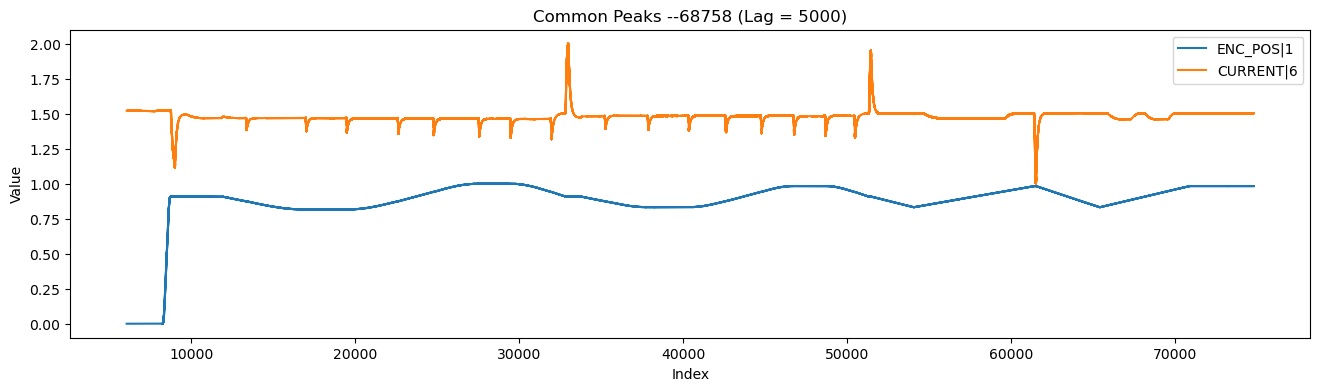

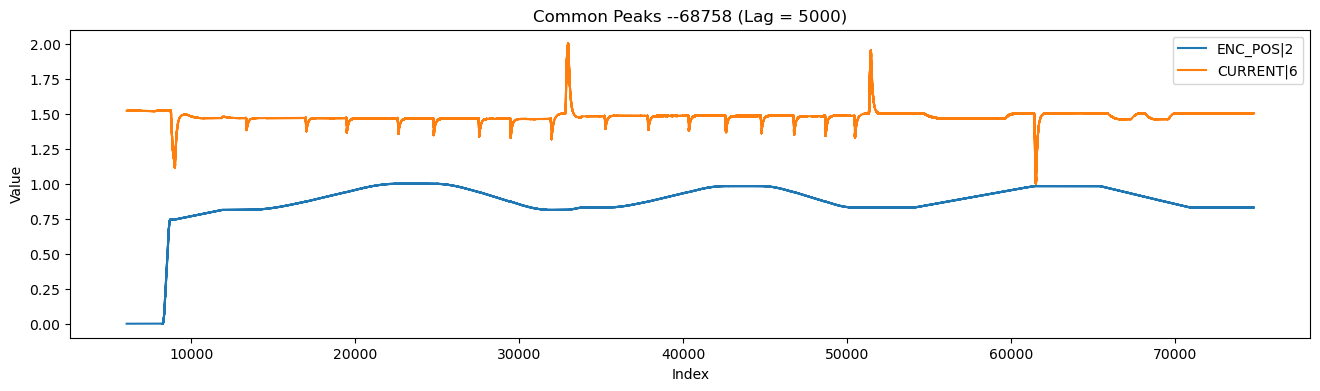

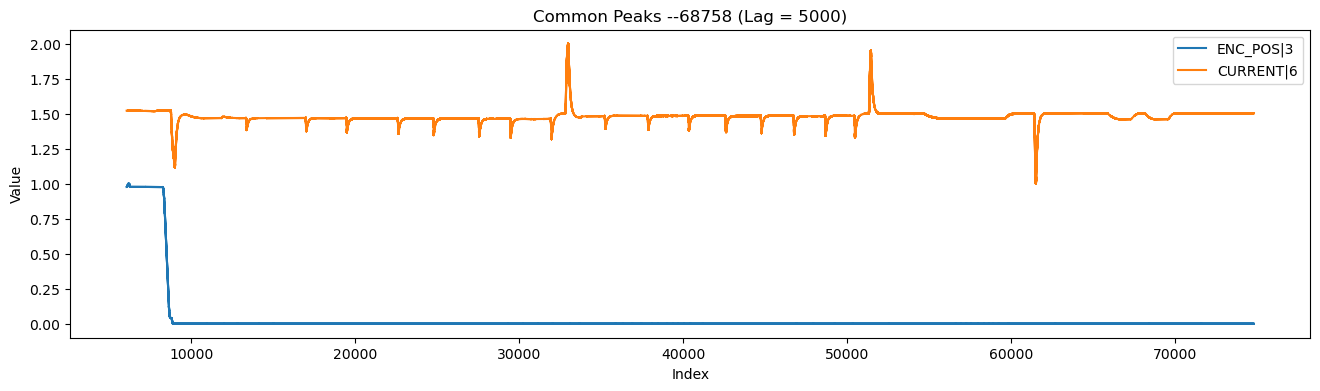

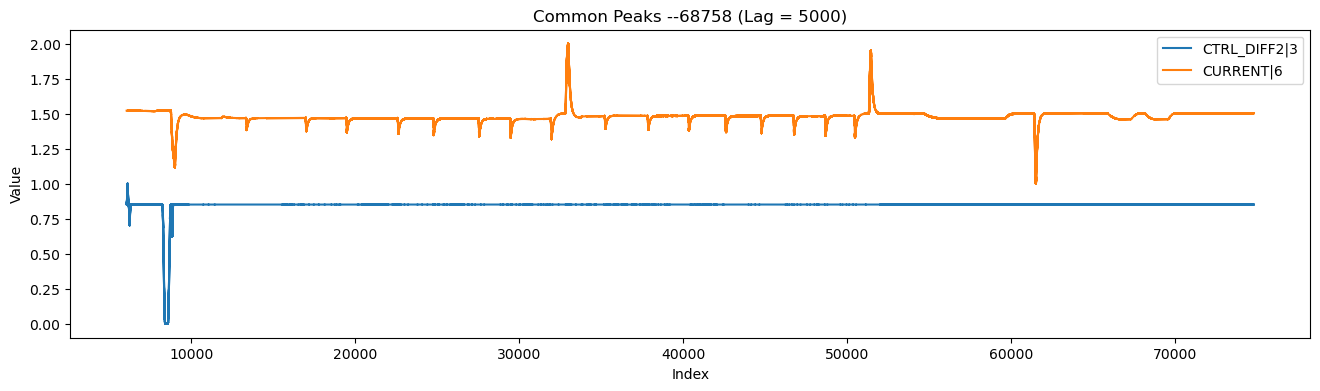

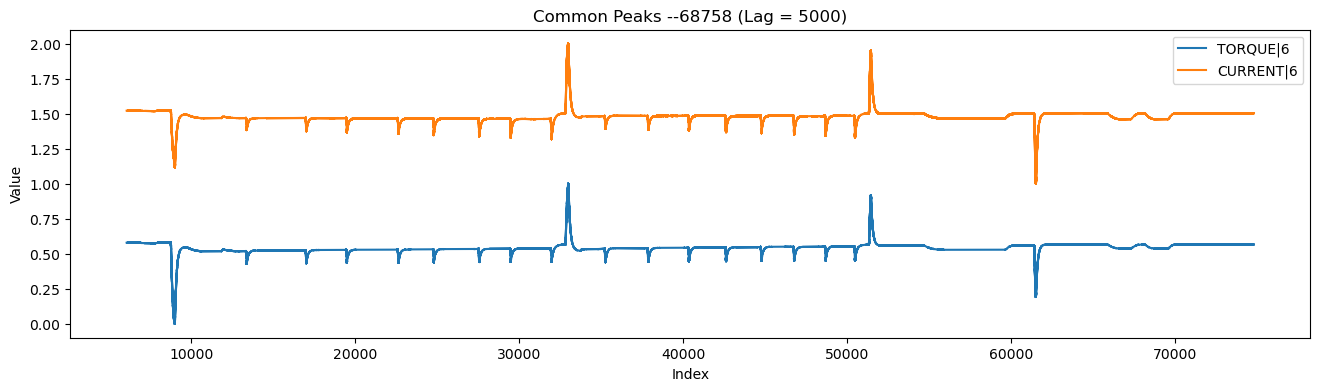

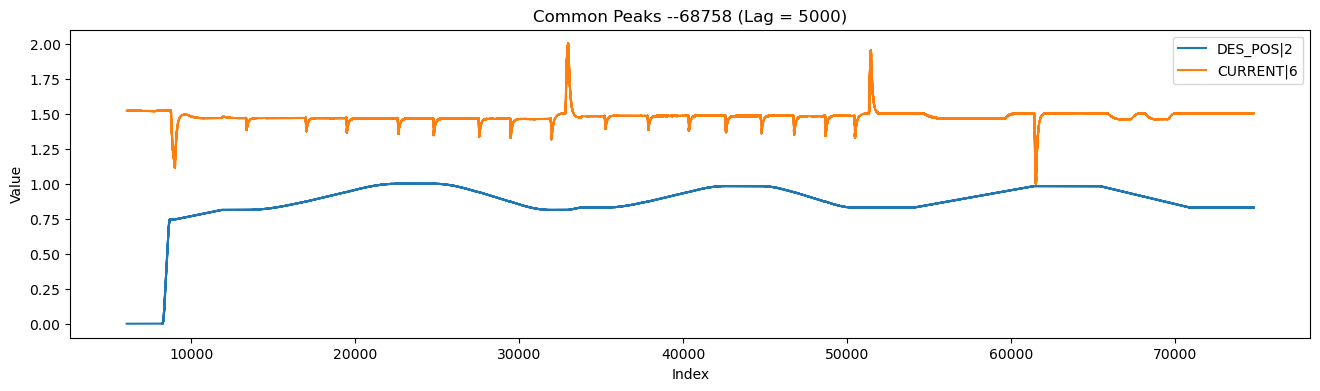

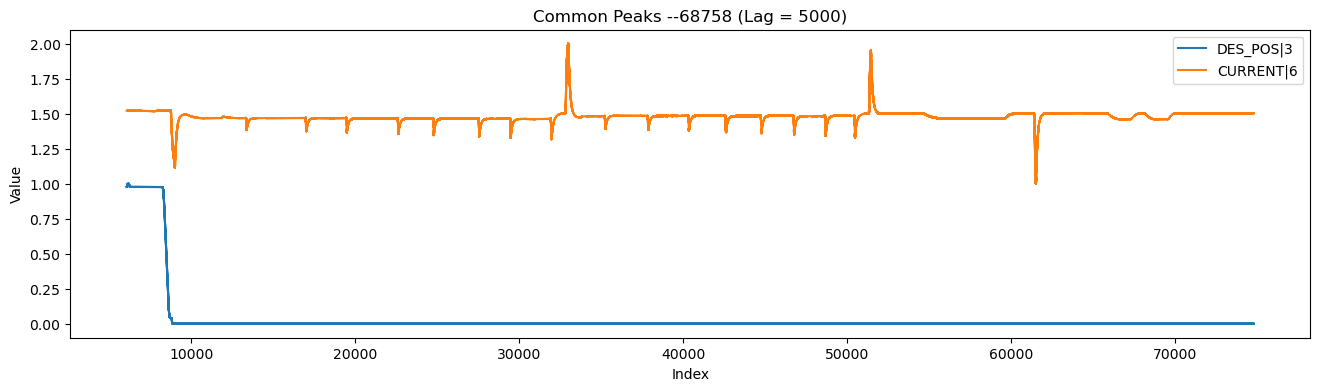

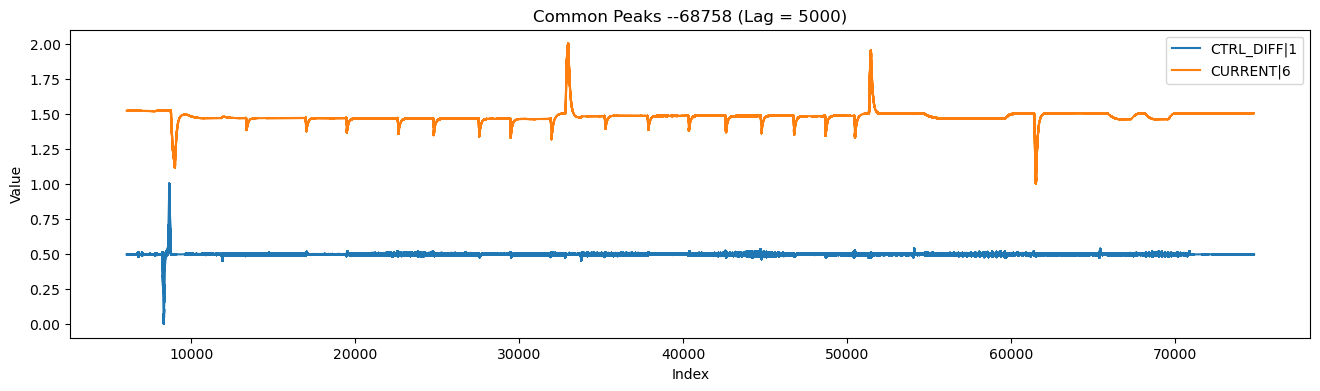

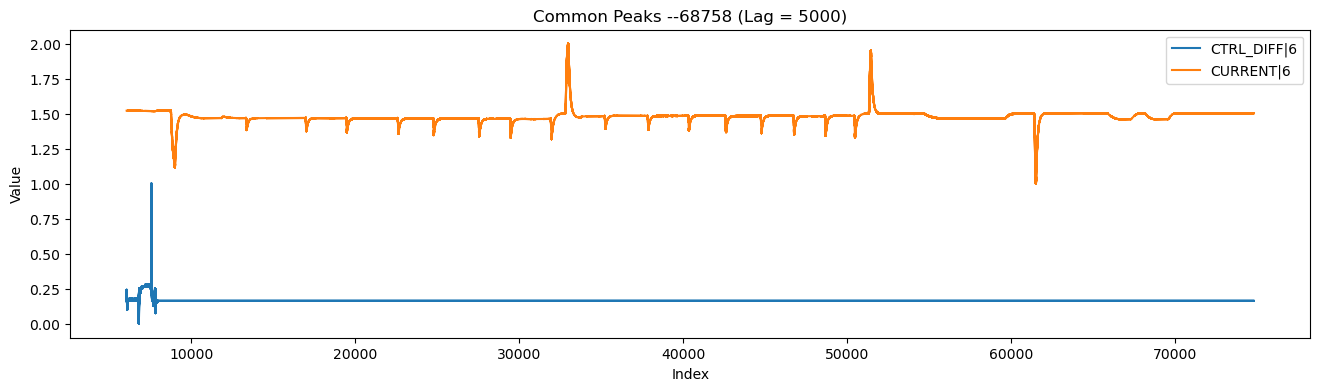

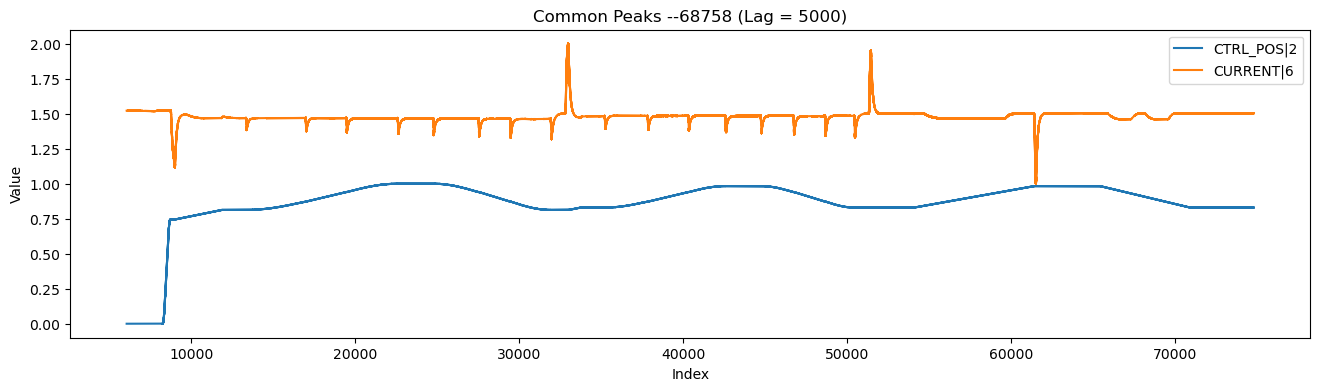

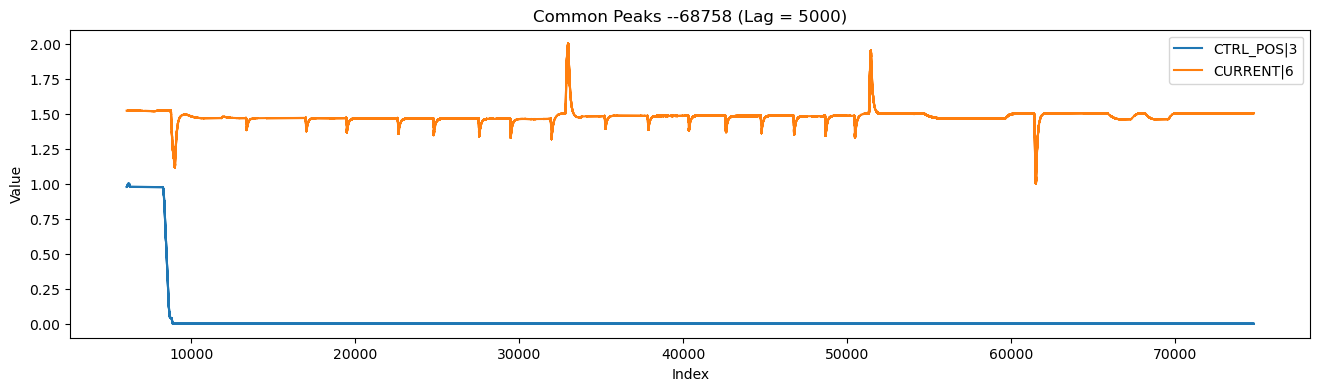

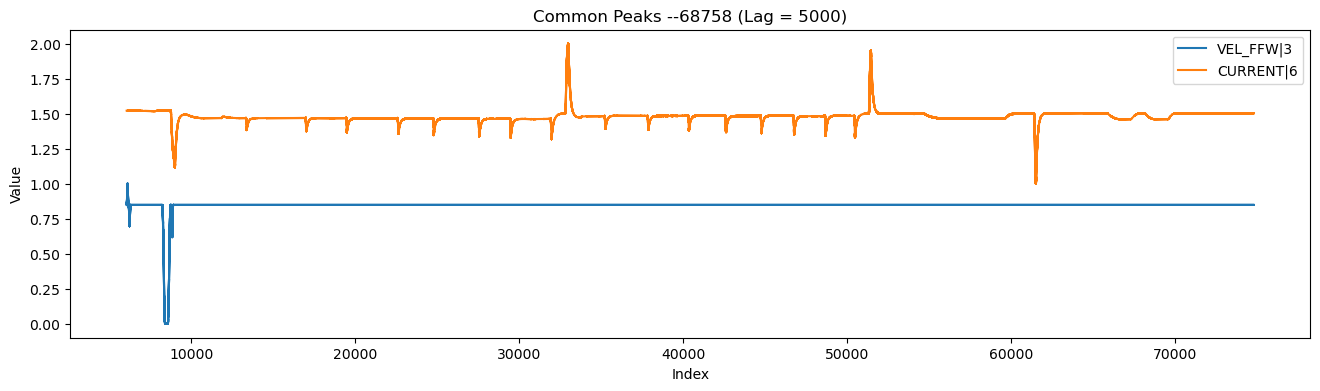

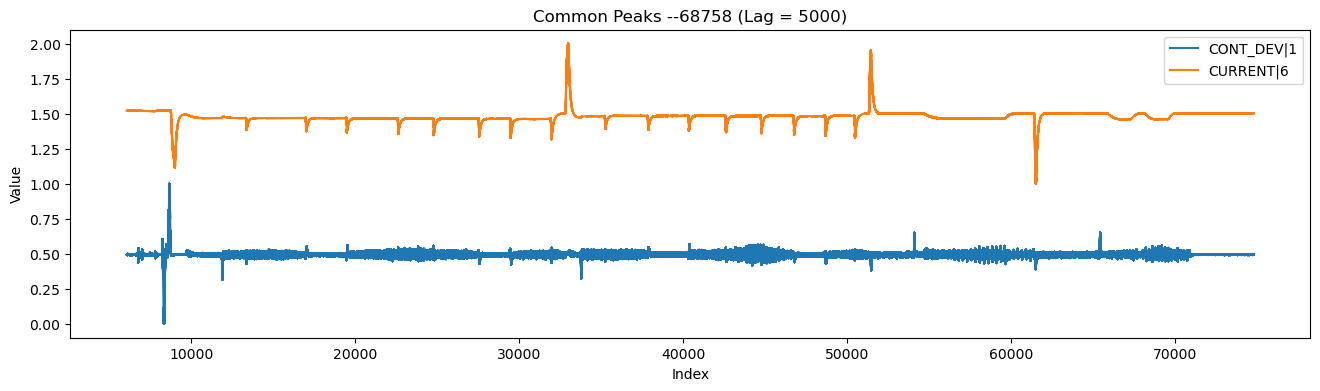

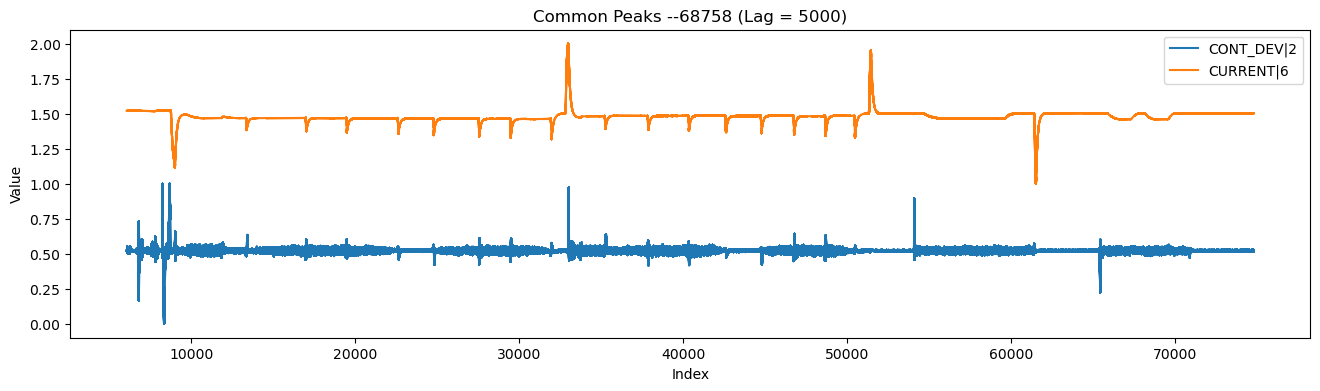

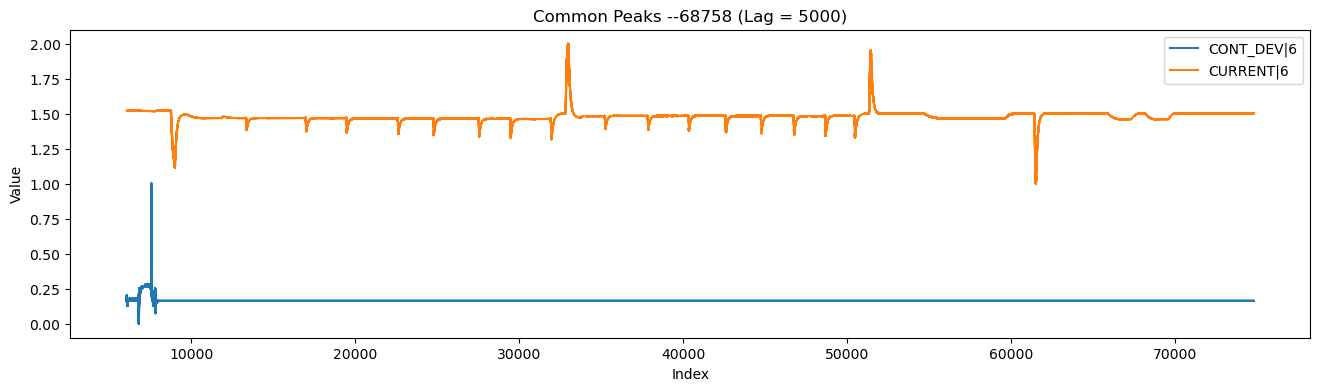

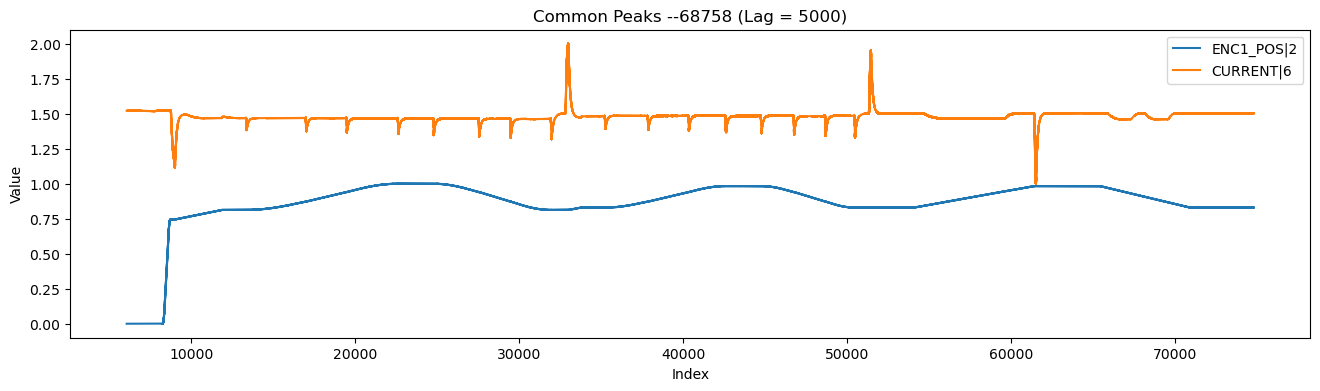

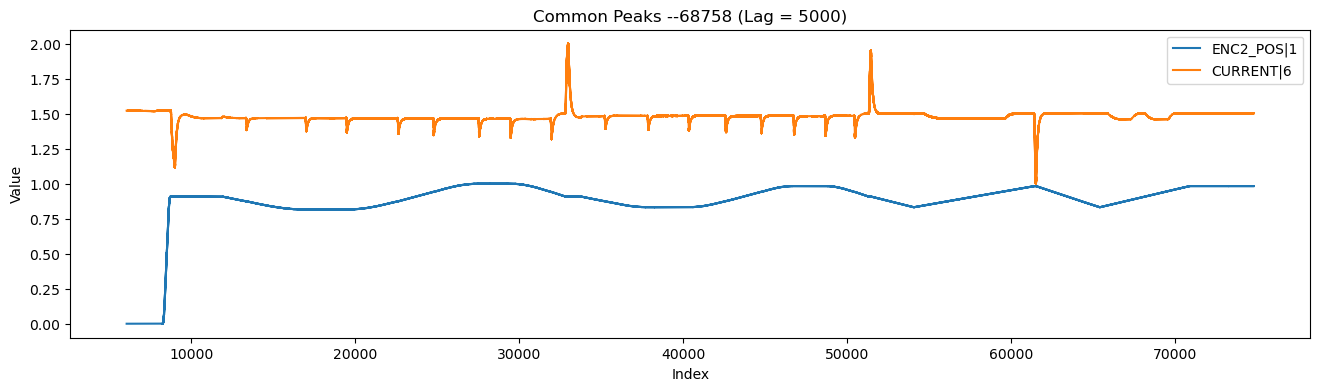

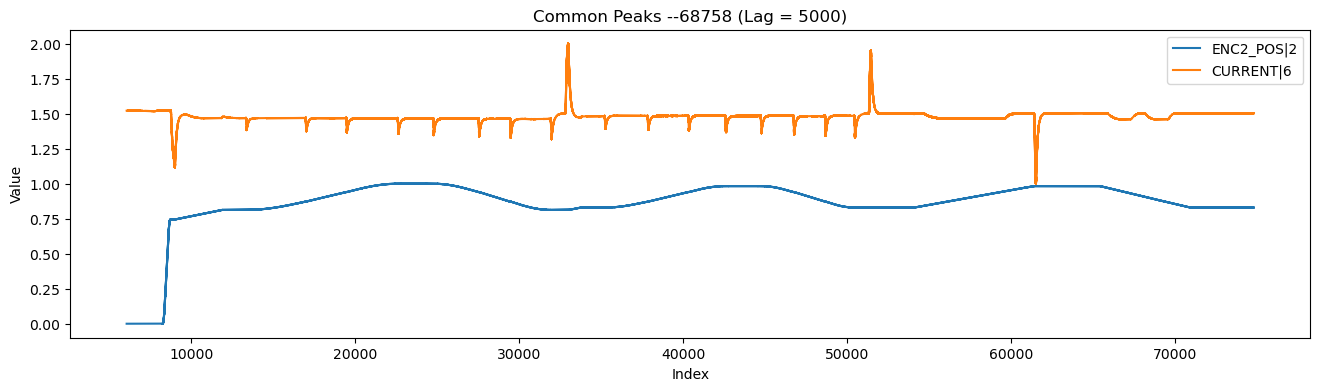

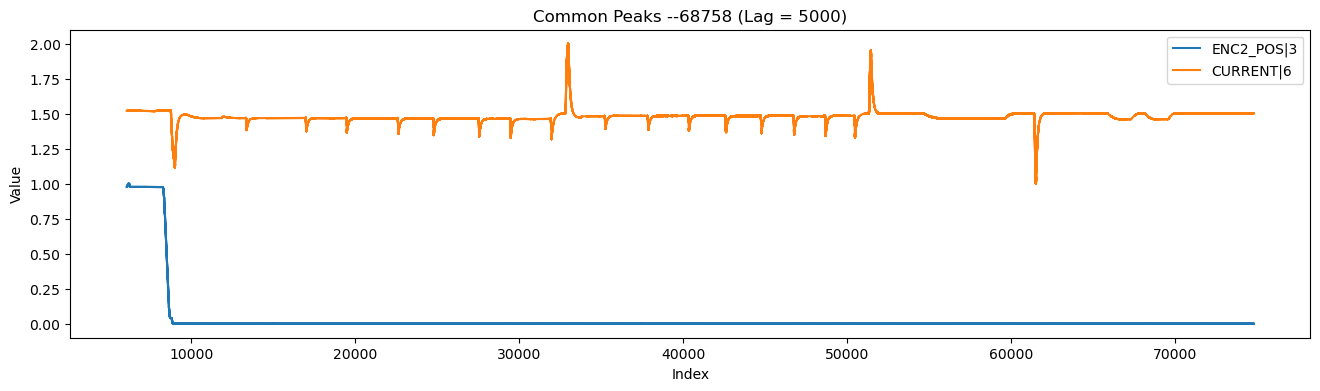

In [6]:
peak_info = pd.read_csv(peaks_info_list[0])
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]

df = pd.read_csv(file_path[0])
print("DF - 1")
plot_common_peaks(df, max_peaks)


DF - 2


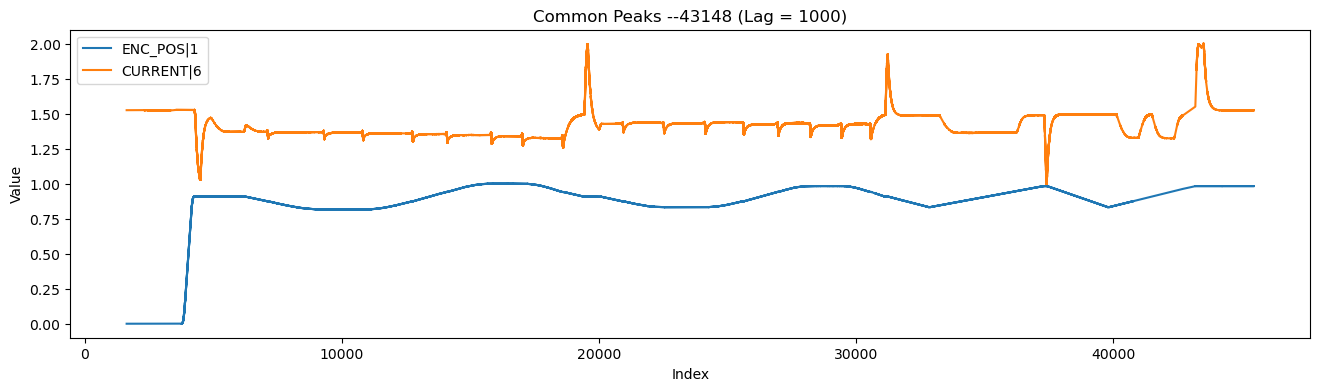

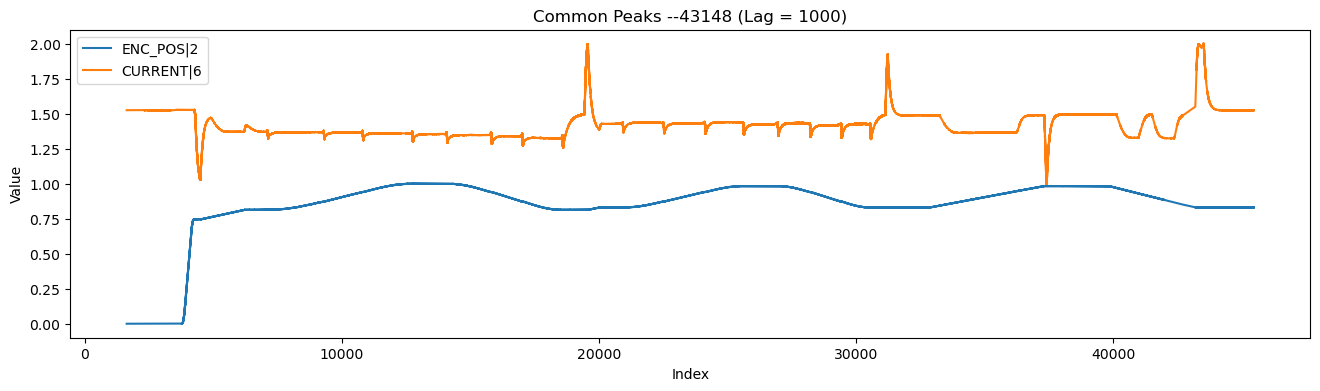

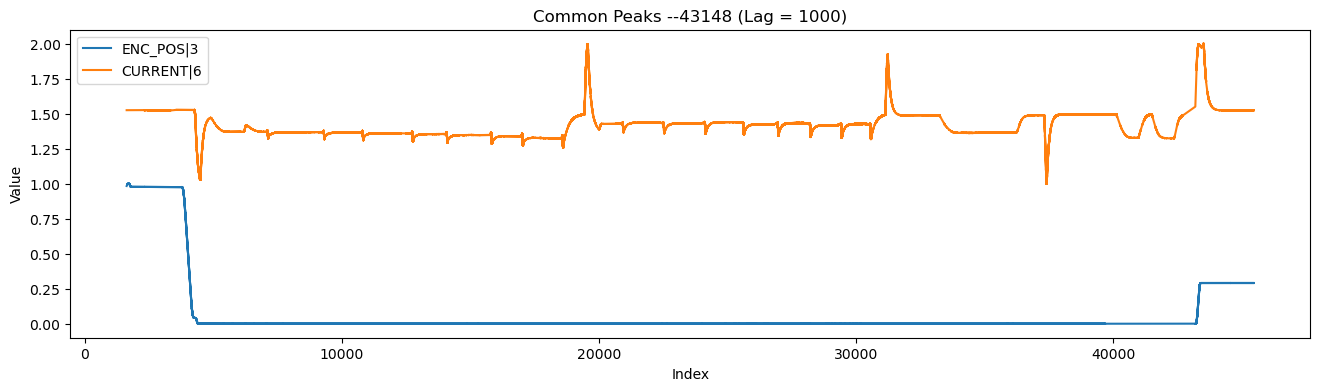

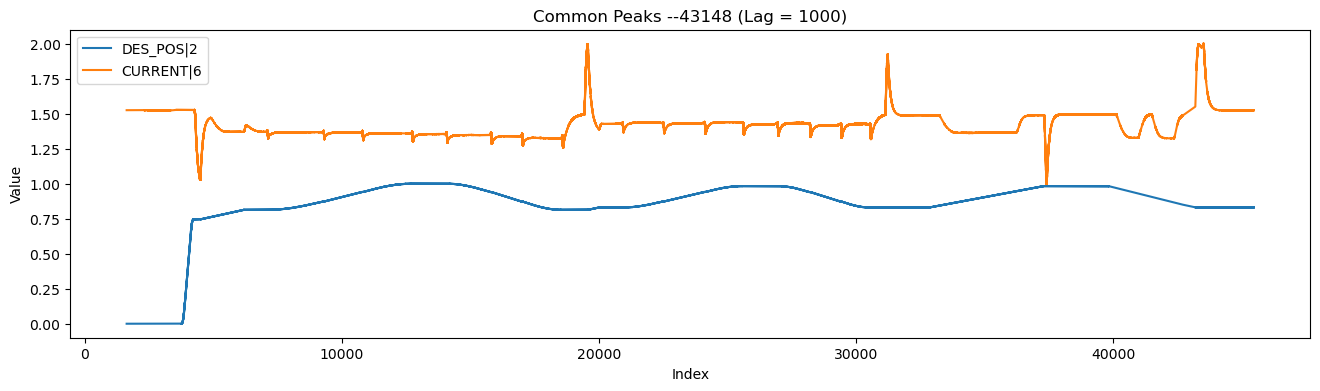

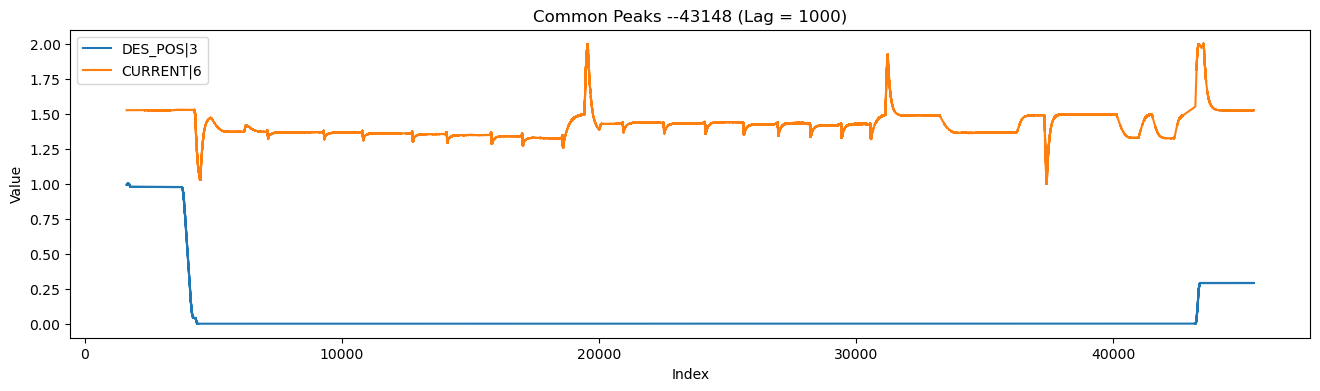

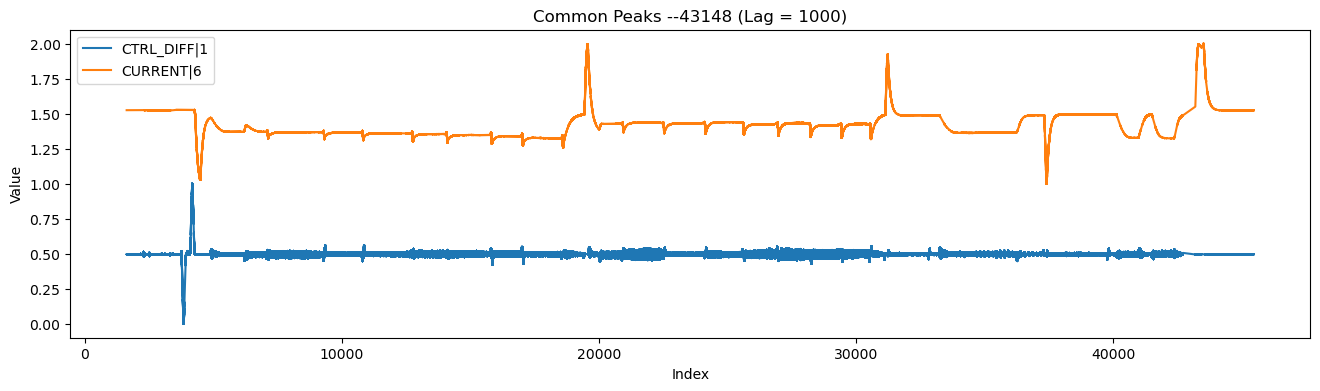

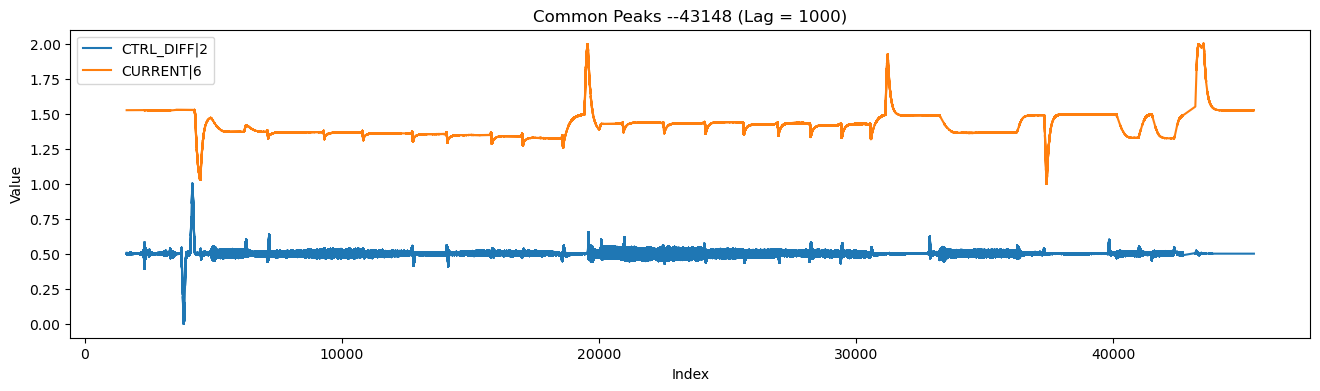

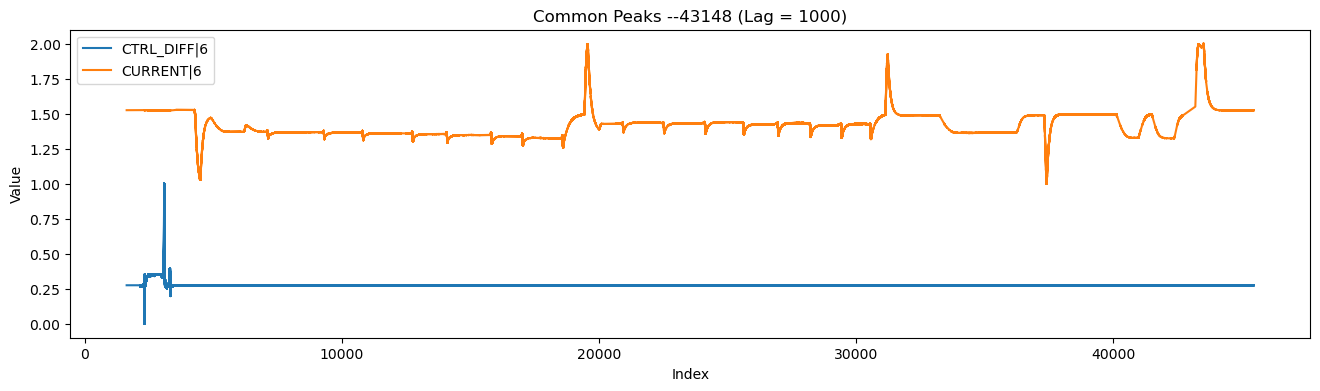

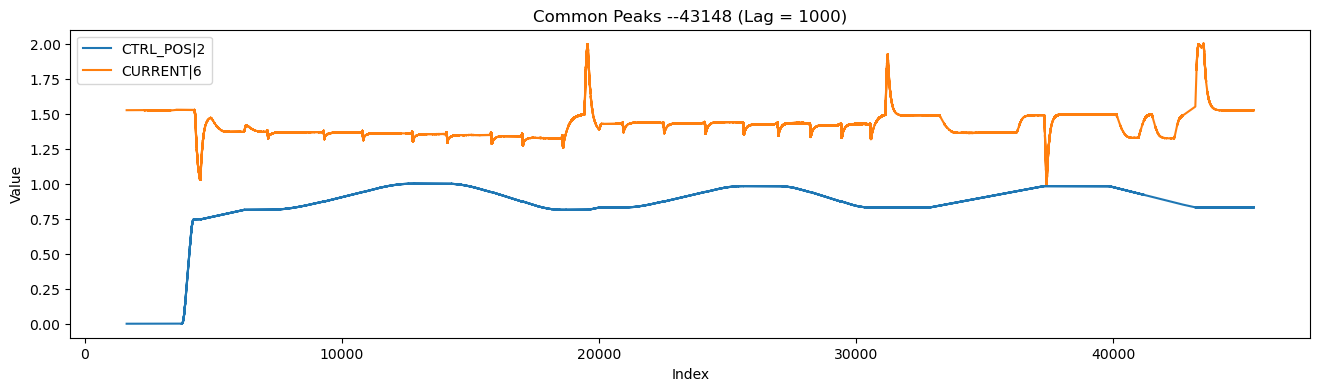

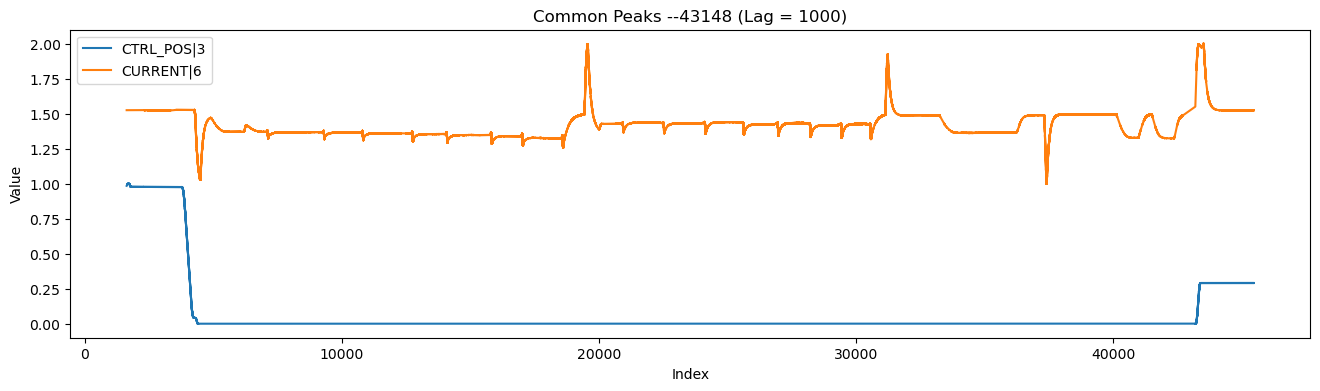

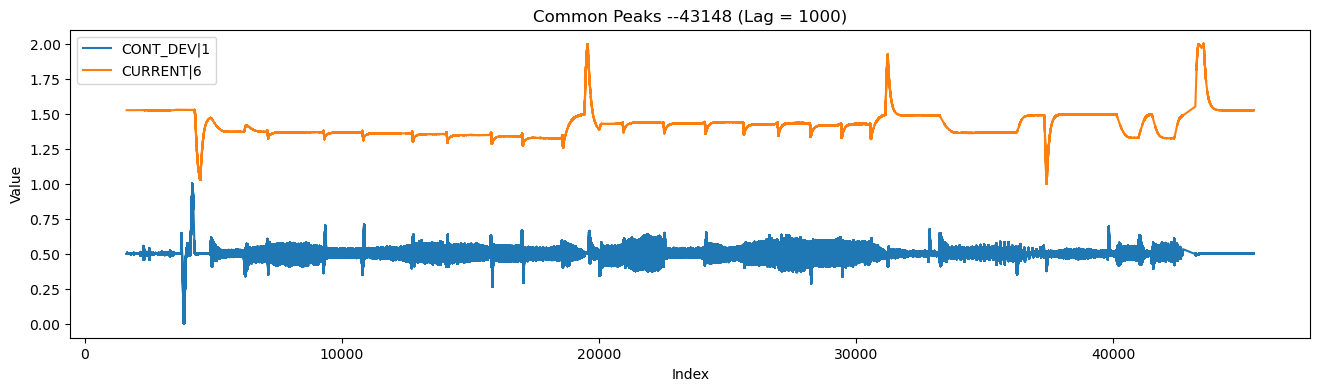

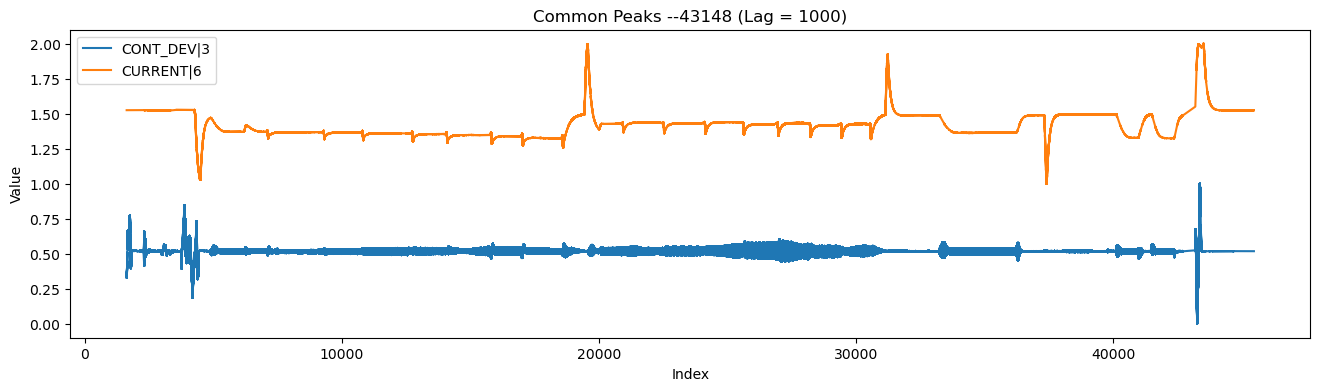

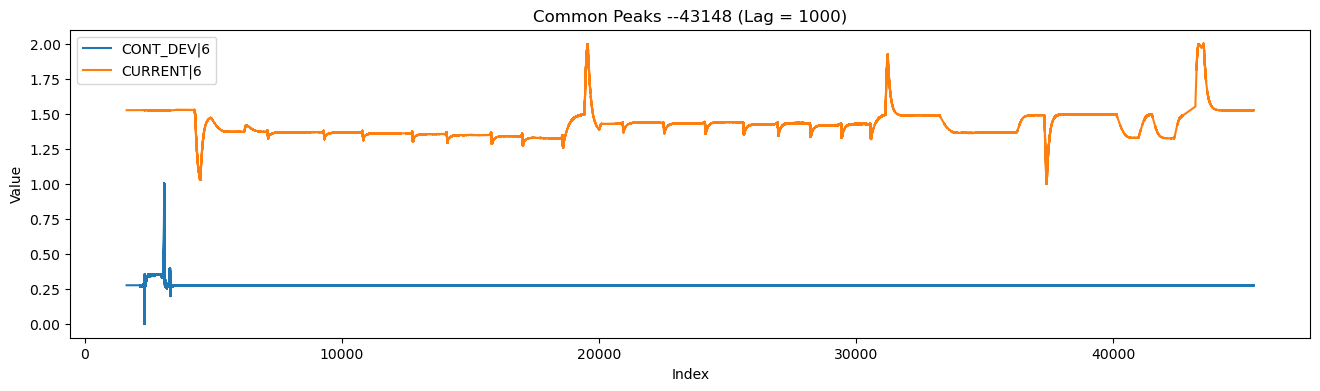

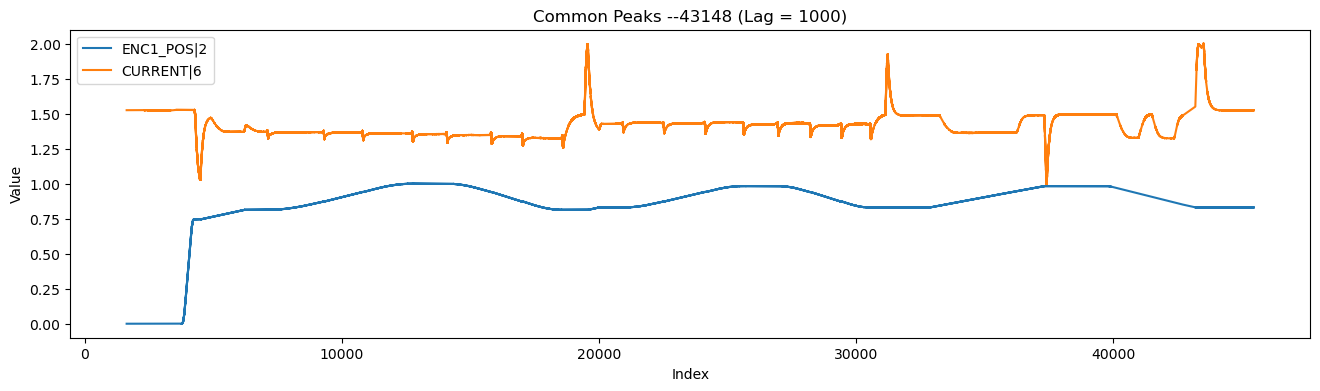

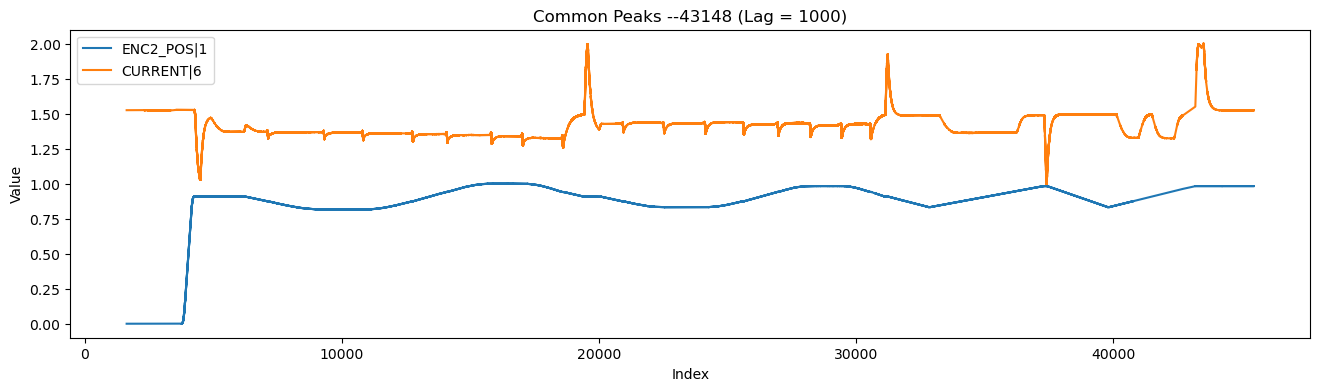

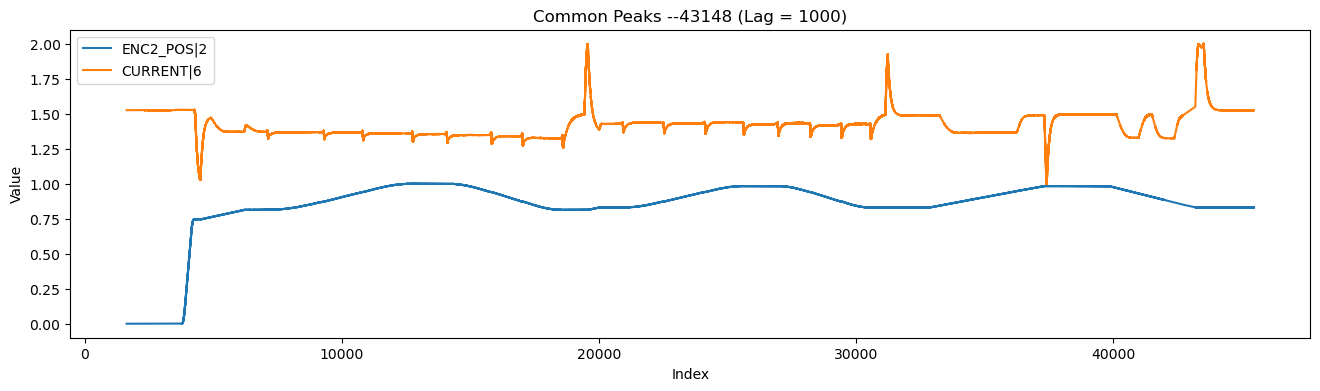

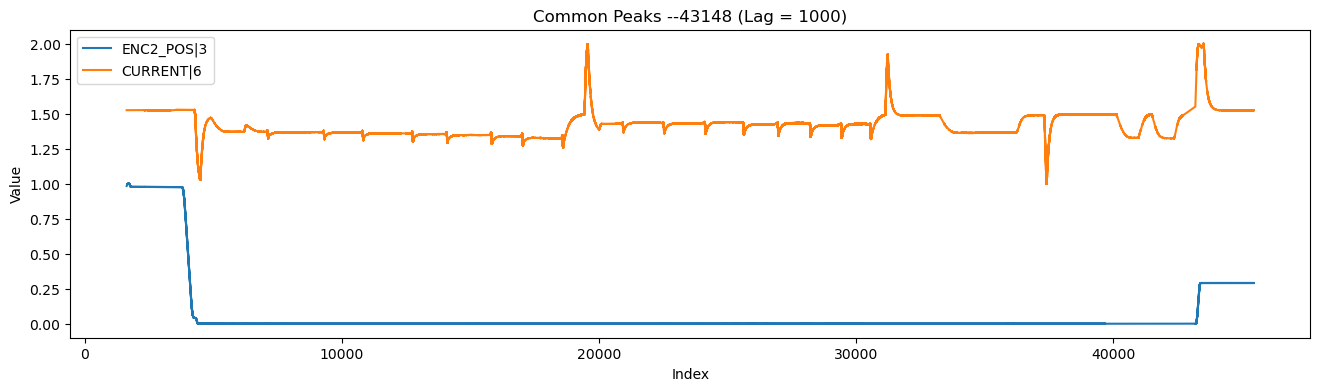

In [7]:
peak_info = pd.read_csv(peaks_info_list[1])
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]

df = pd.read_csv(file_path[1])
print("DF - 2")
plot_common_peaks(df, max_peaks)


DF - 3


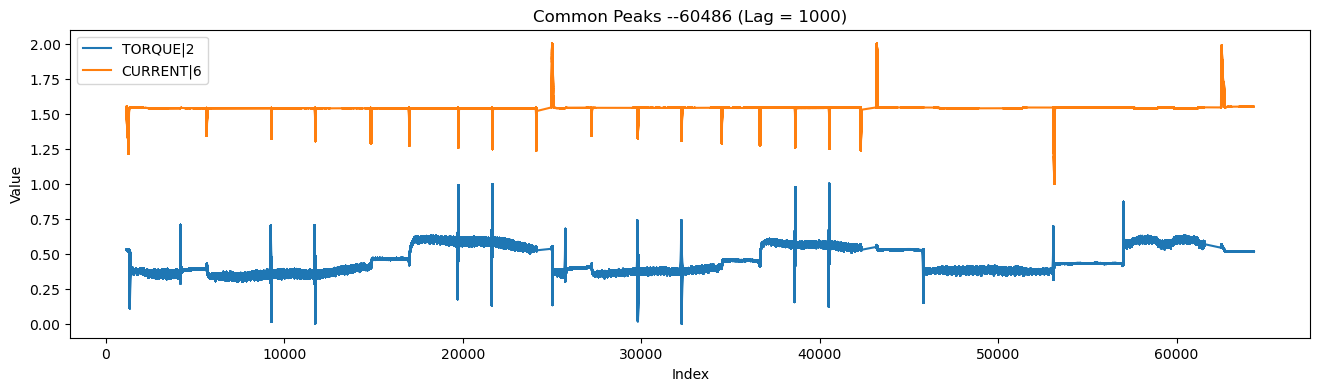

In [52]:
peak_info = pd.read_csv(peaks_info_list[2])
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]

df = pd.read_csv(file_path[2])
print("DF - 3")
plot_common_peaks(df, max_peaks)


DF - 4


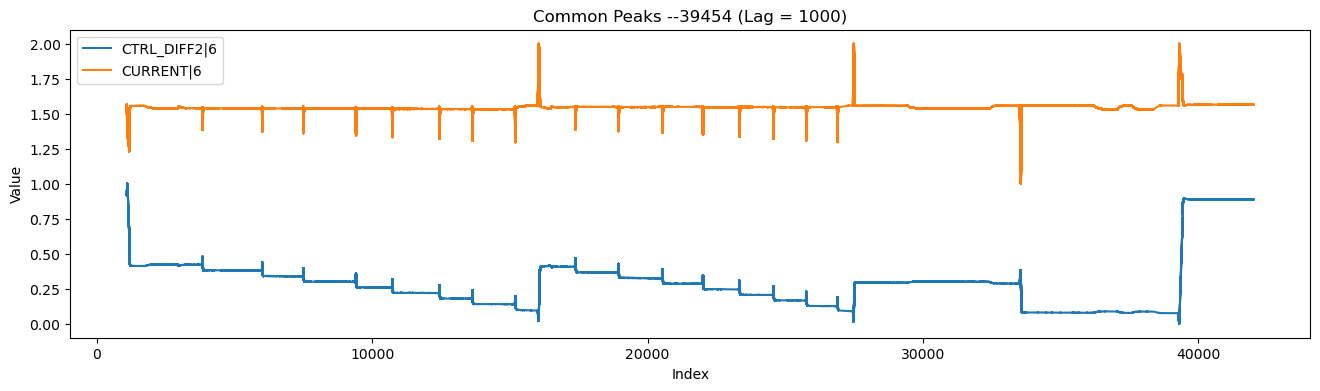

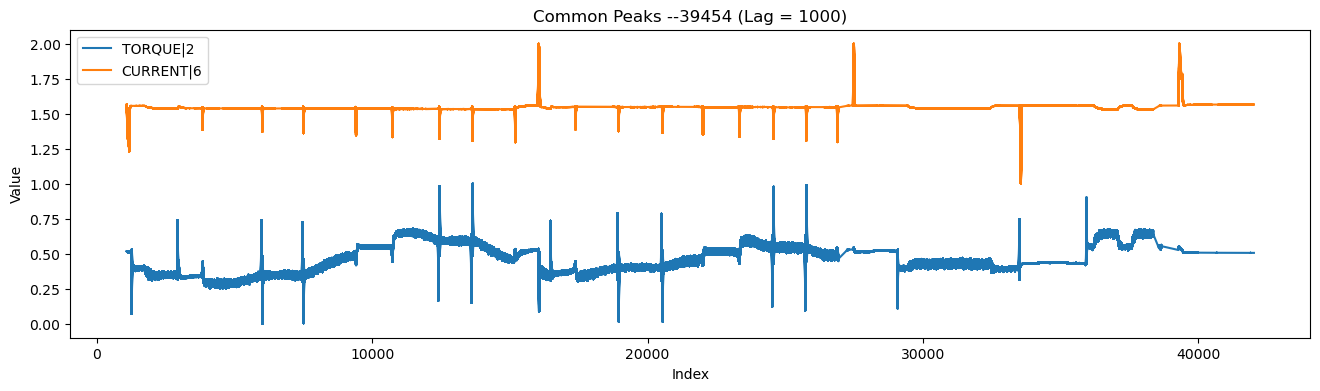

In [9]:
peak_info = pd.read_csv(peaks_info_list[3])
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]

df = pd.read_csv(file_path[3])
print("DF - 4")
plot_common_peaks(df, max_peaks)


## -

In [7]:
#result_df = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Train_RMSE', 'Test_R2', 'Test_RMSE'])
result_df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/PeakAwareModel/PeaksSummary.csv')
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/PeakAwareModel/'
base_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/LSTM_Peak_ZScore/ClassificationResults/'
filenamefinal = os.path.join(output_folder, 'PeaksSummary.csv')


In [23]:
def split_rf(X,y, model):
    # Step 1: Split X into 20% train and 80% test
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Step 2: Use the rfmodel to predict peaks on the training set
    peak_predictions_train = model.predict(X_train)
    peak_predictions_test = model.predict(X_test)

    # Step 3: Separate peak and non-peak data points in the training set
    X_train_peak = X_train[peak_predictions_train == 1]
    y_train_peak = y_train[peak_predictions_train == 1]
    X_train_non_peak = X_train[peak_predictions_train == 0]
    y_train_non_peak = y_train[peak_predictions_train == 0]

    # Step 4: Separate peak and non-peak data points in the test set
    X_test_peak = X_test[peak_predictions_test == 1]
    y_test_peak = y_test[peak_predictions_test == 1]
    X_test_non_peak = X_test[peak_predictions_test == 0]
    y_test_non_peak = y_test[peak_predictions_test == 0]

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak


In [8]:
def split_lstm(X,y, model):
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_X.fit(X)
    scaler_y.fit(y)
    
    peak_predictions_train = model.predict(X_train)
    peak_predictions_test = model.predict(X_test)

    X_train_peak = X_train[peak_predictions_train == 1]
    y_train_peak = y_train[peak_predictions_train == 1]
    X_train_non_peak = X_train[peak_predictions_train == 0]
    y_train_non_peak = y_train[peak_predictions_train == 0]
    X_train_peak = scaler_X.transform(X_train_peak)
    X_train_non_peak = scaler_X.transform(X_train_non_peak)
    y_train_peak = scaler_y.transform(y_train_peak)
    y_train_non_peak = scaler_y.transform(y_train_non_peak)

    X_test_peak = X_test[peak_predictions_test == 1]
    y_test_peak = y_test[peak_predictions_test == 1]
    X_test_non_peak = X_test[peak_predictions_test == 0]
    y_test_non_peak = y_test[peak_predictions_test == 0]
    X_test_peak = scaler_X.transform(X_test_peak)
    y_test_peak = scaler_y.transform(y_test_peak)
    X_test_non_peak = scaler_X.transform(X_test_non_peak)
    y_test_non_peak = scaler_y.transform(y_test_non_peak)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak, scaler_X, scaler_y


In [22]:
i=3
df = pd.read_csv(file_path[i])
df = df.abs()
X = df[not_non_features]
y = df[[target]]
rf_model = joblib.load(os.path.join(base_folder, f'RF_Data{i+1}_Classes.csv.pkl'))
xgb_model = joblib.load(os.path.join(base_folder, f'XGB_Data{i+1}_Classes.csv.pkl'))


#X_train_peakrf, y_train_peakrf, X_train_non_peakrf, y_train_non_peakrf, X_test_peakrf, y_test_peakrf, X_test_non_peakrf, y_test_non_peakrf = split_rf(X, y, xgb_model)
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak, scaler_X, scaler_y = split_lstm(X, y, xgb_model)



#### Random Forest

In [51]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_peakrf, y_train_peakrf)
train_pred = rf_model.predict(X_train_peakrf)
test_pred = rf_model.predict(X_test_peakrf)
#print(y_pred)
y_train = y_train_peakrf.squeeze()
y_test = y_test_peakrf.squeeze()

train_df = pd.DataFrame({
        'Train_y': y_train,
        'Train_pred_y': train_pred })
filename = os.path.join(output_folder, f'p_trains_rf_xgb_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)

test_df = pd.DataFrame({
        'Test_y': y_test,
        'Test_pred_y': test_pred })
filename = os.path.join(output_folder, f'p_tests_rf_xgb_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_pred)

result_df = result_df.append({
    'Dataset': f'Peak_RFR_XGB_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
    }, ignore_index=True)

result_df.to_csv(filenamefinal, index=False)

/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [52]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_non_peakrf, y_train_non_peakrf)
train_pred = rf_model.predict(X_train_non_peakrf)
test_pred = rf_model.predict(X_test_non_peakrf)
#print(y_pred)
y_train = y_train_non_peakrf.squeeze()
y_test = y_test_non_peakrf.squeeze()

train_df = pd.DataFrame({
        'Train_y': y_train,
        'Train_pred_y': train_pred })
filename = os.path.join(output_folder, f'np_trains_rf_xgb_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)

test_df = pd.DataFrame({
        'Test_y': y_test,
        'Test_pred_y': test_pred })
filename = os.path.join(output_folder, f'np_tests_rf_xgb_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_pred)

result_df = result_df.append({
    'Dataset': f'NonPeak_RFR_XGB_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
    }, ignore_index=True)

result_df.to_csv(filenamefinal, index=False)

/home/genty/.local/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### LSTM

In [23]:
time_step = 60

X_train, y_train = create_dataset(X_train_peak, y_train_peak, time_step)
X_test, y_test = create_dataset(X_test_peak, y_test_peak, time_step)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform predictions
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test)

train_df = pd.DataFrame({
        'Train_y': y_train_inv.flatten(),
        'Train_pred_y': train_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'p_trains_lstm_xgb_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)
test_df = pd.DataFrame({
        'Test_y': y_test_inv.flatten(),
        'Test_pred_y': test_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'p_tests_lstm_xgb_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

# Calculate R2 and RMSE
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

# Append the results to the dataframe
result_df = result_df.append({
    'Dataset': f'Peak_LSTM_XGB_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
}, ignore_index=True)

result_df.to_csv(filenamefinal, index=False)

Epoch 1/50


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0011 - val_loss: 0.0161
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.0644e-04 - val_loss: 0.0171
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 6.1703e-04 - val_loss: 0.0153
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 6.7788e-04 - val_loss: 0.0166
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.8717e-04 - val_loss: 0.0151
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 5.8311e-04 - val_loss: 0.0133
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 6.1789e-04 - val_loss: 0.0129
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.1853e-04 - val_loss: 0.0107
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 7.8660e-04 - val_loss: 0.0126
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 4.9021e-04 - val_loss: 0.0124
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━

In [24]:
time_step = 60

X_train, y_train = create_dataset(X_train_non_peak, y_train_non_peak, time_step)
X_test, y_test = create_dataset(X_test_non_peak, y_test_non_peak, time_step)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform predictions
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test)

train_df = pd.DataFrame({
        'Train_y': y_train_inv.flatten(),
        'Train_pred_y': train_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'np_trains_lstm_xgb_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)
test_df = pd.DataFrame({
        'Test_y': y_test_inv.flatten(),
        'Test_pred_y': test_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'np_tests_lstm_xgb_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

# Calculate R2 and RMSE
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

# Append the results to the dataframe
result_df = result_df.append({
    'Dataset': f'NonPeak_LSTM_XGB_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
}, ignore_index=True)

result_df.to_csv(filenamefinal, index=False)

Epoch 1/50


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 1.9543e-04 - val_loss: 0.0046
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 1.7273e-04 - val_loss: 0.0034
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 2.5143e-04 - val_loss: 0.0032
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 1.9339e-04 - val_loss: 0.0024
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 1.7603e-04 - val_loss: 0.0018
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 9.1252e-05 - val_loss: 0.0016
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - loss: 1.1781e-04 - val_loss: 0.0019
Epoch 9/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 1.1145e-04 - val_loss: 0.0019
Epoch 10/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 7.7637e-05 - val_loss: 0.0015
Epoch 11/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 8.6481e-05 - val_loss: 0.0017
E